# PREDICCIONES COMPLETAS + INDEC  COMPARATIVA

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [3]:
# Read vCensosAmba
df_indec = read_table_into_dataframe('public.proyecciones')
df_indec=df_indec.sort_values(by=['Departamento', 'ano'])


    # Example usage:
# # Assuming 'df' is your DataFrame
# dataframe_to_image(df.head(), 'output', 'svg')  # Save as SVG image
# dataframe_to_image(df.head(), 'output', 'jpeg') # Save as JPEG image
df_indec.tail(15)


,id,CodigoDpto,ano,Departamento,Poblacion,Varones,Mujeres
45,430,6861,2011,Vicente López,271677,127508,144169
68,453,6861,2012,Vicente López,271078,127315,143763
91,476,6861,2013,Vicente López,270598,127130,143468
114,499,6861,2014,Vicente López,270139,126954,143185
137,522,6861,2015,Vicente López,269705,126790,142915
160,545,6861,2016,Vicente López,269294,126636,142658
183,568,6861,2017,Vicente López,268897,126492,142405
206,591,6861,2018,Vicente López,268509,126358,142151
229,614,6861,2019,Vicente López,268064,126235,141829
252,637,6861,2020,Vicente López,267655,126124,141531


In [4]:
# proyecciones- Datasetc EXTENDIDO _V4.csv
df_proy = pd.read_csv('C:/Users/Fer/ITBA_TFI/datasets/extended_All.csv',sep=',', header='infer')

# Display the first few rows of the DataFrame
df_proy=df_proy.rename(columns={'anio':'ano','nam':'Departamento'})
df_proy.head()

,Departamento,cod_depto,ano,pob,var,muj,vivpart,vivtotal,sup,ind_masc,...,MSE_RT,RMSE_RT,Pred_RF,MSE_RF,RMSE_RF,MAPE_RF,Pred_LGB,MSE_LGB,RMSE_LGB,MAPE_LGB
0,Almirante Brown,6028,1991,450698.0,222042.0,228656.0,NaN,NaN,157.87,97.1,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Almirante Brown,6028,2010,552902.0,270247.0,282655.0,156218.0,78.0,157.87,95.6,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Almirante Brown,6028,2022,585852.0,281842.0,301779.0,184403.0,60.0,157.87,93.4,...,1085702500,32950.0,521336.0,4.162335e+09,64516.16,11.012,506385.0,6.314951e+09,79466.666667,13.56429
3,Almirante Brown,6028,2001,515556.0,252454.0,263102.0,143543.0,88.0,157.87,96.0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Avellaneda,6035,2001,328980.0,155450.0,173530.0,117200.0,59.0,68.54,89.6,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### MERGE

In [5]:
# Perform the merge based on the columns 'anio' and 'nam'
merged_df = df_proy.merge(df_indec, on=['ano', 'Departamento'], how='left')
FullProy_df=merged_df.drop(columns=['id','CodigoDpto','Varones','Mujeres'])
FullProy_df=FullProy_df.rename(columns={'Poblacion':'Pred_INDEC'})
FullProy_df.tail(15)


,Departamento,cod_depto,ano,pob,var,muj,vivpart,vivtotal,sup,ind_masc,...,RMSE_RT,Pred_RF,MSE_RF,RMSE_RF,MAPE_RF,Pred_LGB,MSE_LGB,RMSE_LGB,MAPE_LGB,Pred_INDEC
81,San Miguel,6760,2010,276190.0,134584.0,141606.0,82892.0,57.0,100.72,95.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278019.0
82,San Miguel,6760,2001,253086.0,123400.0,129686.0,71300.0,84.0,100.72,95.2,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,San Miguel,6760,1991,NaN,NaN,NaN,NaN,NaN,100.72,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Tigre,6805,2022,447785.0,215056.0,228822.0,152750.0,54.0,525.28,94.0,...,146562.0,327135.0,1.455631e+10,120649.52,26.944,311842.0,1.848050e+10,135943.000000,30.358989,NaN
85,Tigre,6805,2010,376381.0,184774.0,191607.0,118428.0,54.0,525.28,96.4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,Tigre,6805,2001,301223.0,148057.0,153166.0,87709.0,42.0,525.28,96.7,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,Tigre,6805,1991,257922.0,127987.0,129935.0,NaN,NaN,525.28,98.5,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Tres de Febrero,6840,2022,366377.0,173299.0,191265.0,149029.0,67.0,55.29,90.6,...,29910.0,341817.0,6.031769e+08,24559.66,6.703,341971.0,5.956366e+08,24405.666667,6.661353,344172.0
89,Tres de Febrero,6840,2010,340071.0,161806.0,178265.0,119920.0,88.0,55.29,90.8,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343338.0
90,Tres de Febrero,6840,2001,336467.0,159781.0,176686.0,115040.0,92.0,55.29,90.4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Filter the dataset to include only rows where 'Pred_INDEC' is not null
filtered_df = FullProy_df[FullProy_df['Pred_INDEC'].notnull()]

# Calculate the absolute difference between 'pob' and 'Pred_INDEC'
filtered_df['abs_error'] = abs(filtered_df['pob'] - filtered_df['Pred_INDEC'])

# Calculate MSE
filtered_df['MSE'] = mean_squared_error(filtered_df['pob'] , filtered_df['Pred_INDEC']).round(1)

# Calculate RMSE
filtered_df['RMSE'] =np.sqrt(mean_squared_error(filtered_df['pob'] , filtered_df['Pred_INDEC'])).round(1)

# Calculate the percentage error for each row- MAPE
filtered_df['percentage_error'] = (filtered_df['abs_error'] / filtered_df['pob']).round(4) * 100

# Compute the mean of the absolute percentage errors
mape = filtered_df['percentage_error'].mean()

# Add the calculated MAPE values as a new column
FullProy_df.loc[FullProy_df['Pred_INDEC'].notnull(), 'MAPE_Pred_INDEC'] = filtered_df['percentage_error']
# Add the calculated MSE values as a new column
FullProy_df.loc[FullProy_df['Pred_INDEC'].notnull(), 'MSE_INDEC'] = filtered_df['MSE']
# Add the calculated RMSE values as a new column
FullProy_df.loc[FullProy_df['Pred_INDEC'].notnull(), 'RMSE_INDEC'] = filtered_df['RMSE']

print("Mean Absolute Percentage Error (MAPE):", mape)
# Convert 'ano' column to integers
FullProy_df['ano'] = FullProy_df['ano'].astype(int)
# Sort FullProy_df by 'ano' and 'Departamento'
FullProy_df_sorted = FullProy_df.sort_values(by=['Departamento'])
FullProy_df_sorted.head()
# 

Mean Absolute Percentage Error (MAPE): 3.385652173913044


C:\Users\Fer\AppData\Local\Temp\ipykernel_19924\2186190763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['abs_error'] = abs(filtered_df['pob'] - filtered_df['Pred_INDEC'])
C:\Users\Fer\AppData\Local\Temp\ipykernel_19924\2186190763.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['MSE'] = mean_squared_error(filtered_df['pob'] , filtered_df['Pred_INDEC']).round(1)
C:\Users\Fer\AppData\Local\Temp\ipykernel_19924\2186190763.py:11: SettingWithCopyWarning: 
A value is trying to be

,Departamento,cod_depto,ano,pob,var,muj,vivpart,vivtotal,sup,ind_masc,...,RMSE_RF,MAPE_RF,Pred_LGB,MSE_LGB,RMSE_LGB,MAPE_LGB,Pred_INDEC,MAPE_Pred_INDEC,MSE_INDEC,RMSE_INDEC
0,Almirante Brown,6028,1991,450698.0,222042.0,228656.0,NaN,NaN,157.87,97.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Almirante Brown,6028,2010,552902.0,270247.0,282655.0,156218.0,78.0,157.87,95.6,...,NaN,NaN,NaN,NaN,NaN,NaN,557025.0,0.75,6.527387e+09,80792.2
2,Almirante Brown,6028,2022,585852.0,281842.0,301779.0,184403.0,60.0,157.87,93.4,...,64516.16,11.012,506385.0,6.314951e+09,79466.666667,13.56429,605271.0,3.31,6.527387e+09,80792.2
3,Almirante Brown,6028,2001,515556.0,252454.0,263102.0,143543.0,88.0,157.87,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Avellaneda,6035,2001,328980.0,155450.0,173530.0,117200.0,59.0,68.54,89.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Variance Analisis


##### Grouping by Mean

In [26]:
# Step 1: Filter the dataset for the year 2022
data_2022 = FullProy_df[FullProy_df['ano'] == 2022]

# Step 2: Calculate the average MAPE for each 'Departamento'
average_mape = data_2022.groupby('Departamento')[['MAPE_LR', 'MAPE_RT', 'MAPE_RF', 'MAPE_LGB', 'MAPE_Pred_INDEC']].mean()

# Step 3: Classify 'Departamento' based on average MAPE
# You can define your classification criteria based on the average MAPE values
# For example, you can consider lower MAPE values as better predictions

def classify_mape(row):
    if row.mean() < 5:
        return 'Excellent'
    elif 5 <= row.mean() < 10:
        return 'Good'
    elif 10 <= row.mean() < 15:
        return 'Fair'
    else:
        return 'Poor'

average_mape['Prediction_Class'] = average_mape.apply(classify_mape, axis=1)

# Display the average MAPE and the classification
print(average_mape)


                     MAPE_LR  MAPE_RT  MAPE_RF   MAPE_LGB  MAPE_Pred_INDEC  \
Departamento                                                                 
Almirante Brown         2.88      5.6   11.012  13.564290             3.31   
Avellaneda              2.70      7.6    8.903   8.641942             3.35   
Berazategui             3.36     20.2   18.003  20.768276             3.41   
Esteban Echeverría     11.18     28.0   17.772  19.306453            13.13   
Ezeiza                 10.00     41.6      NaN        NaN            12.79   
Florencio Varela        6.21     14.4   26.146  31.034233             7.16   
General San Martín      4.74     10.5    9.124   9.392489             5.28   
Hurlingham              3.27      3.1      NaN        NaN             4.53   
Ituzaingó               0.54      6.7      NaN        NaN             1.78   
José C. Paz             3.16     17.9      NaN        NaN             2.79   
La Matanza             34.39      3.4   21.759  24.684210       

In [8]:
# Step 1: Group by 'Prediction_Class'
grouped_by_class = average_mape.groupby('Prediction_Class')

# Step 2: Get the count of 'Departamento' in each class
count_per_class = grouped_by_class.size()

# Step 3: Calculate the mean of MAPE values for each group
mean_per_class = grouped_by_class[['MAPE_LR', 'MAPE_RT', 'MAPE_RF', 'MAPE_LGB', 'MAPE_Pred_INDEC']].mean()

# Step 4: List of 'Departamentos' in each group
departamentos_per_class = grouped_by_class.apply(lambda df: df.index.tolist())

# Display the results
print("Count of 'Departamento' in each Prediction Class:")
print(count_per_class)

print("\nMean MAPE in each Prediction Class:")
print(mean_per_class)

print("\n'Departamentos' in each Prediction Class:")
print(departamentos_per_class)


Count of 'Departamento' in each Prediction Class:
Prediction_Class
Excellent    5
Fair         5
Good         8
Poor         6
dtype: int64

Mean MAPE in each Prediction Class:
                    MAPE_LR  MAPE_RT    MAPE_RF   MAPE_LGB  MAPE_Pred_INDEC
Prediction_Class                                                           
Excellent          2.702000   3.7400   1.419333   1.293588          2.93800
Fair               4.020000  11.2400  15.660400  19.606584          5.59200
Good               4.108750  11.8625   9.080800   9.910174          4.09875
Poor              12.118333  23.5500  24.957800  28.068725         13.02200

'Departamentos' in each Prediction Class:
Prediction_Class
Excellent    [Hurlingham, Ituzaingó, Lanús, San Isidro, Vic...
Fair         [Berazategui, Lomas de Zamora, Merlo, Morón, Q...
Good         [Almirante Brown, Avellaneda, General San Mart...
Poor         [Esteban Echeverría, Ezeiza, Florencio Varela,...
dtype: object


C:\Users\Fer\AppData\Local\Temp\ipykernel_19924\78032757.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  departamentos_per_class = grouped_by_class.apply(lambda df: df.index.tolist())


### PLOTTING BY PRED CLASS

#### Merging datasets

In [9]:
print("FullProy_df columns:", FullProy_df.columns.tolist())
# Reset the index to bring 'Departamento' into the columns
average_mape.reset_index(inplace=True)  # This will ensure 'Departamento' is back in the columns

print("average_mape columns:", average_mape.columns.tolist())


FullProy_df columns: ['Departamento', 'cod_depto', 'ano', 'pob', 'var', 'muj', 'vivpart', 'vivtotal', 'sup', 'ind_masc', 'dens_pob', 'TMI', 'TGF', 'TBN', 'TBM', 'TCV', 'Mat1ria', 'Pred_LR', 'MAPE_LR', 'MSE_LR', 'RMSE_LR', 'PredRegTree', 'MAPE_RT', 'MSE_RT', 'RMSE_RT', 'Pred_RF', 'MSE_RF', 'RMSE_RF', 'MAPE_RF', 'Pred_LGB', 'MSE_LGB', 'RMSE_LGB', 'MAPE_LGB', 'Pred_INDEC', 'MAPE_Pred_INDEC', 'MSE_INDEC', 'RMSE_INDEC']
average_mape columns: ['Departamento', 'MAPE_LR', 'MAPE_RT', 'MAPE_RF', 'MAPE_LGB', 'MAPE_Pred_INDEC', 'Prediction_Class']


In [10]:
# Select specific columns for merging
merged_df = pd.merge(FullProy_df[['Departamento', 'ano', 'pob','Pred_LR', 'MAPE_LR', 'PredRegTree', 'MAPE_RT', 'Pred_RF', 'MAPE_RF', 'Pred_LGB', 'MAPE_LGB', 'Pred_INDEC', 'MAPE_Pred_INDEC']], 
                     average_mape[['Departamento', 'Prediction_Class']],
                     on='Departamento', how='inner')
full_df=merged_df
# Preview the merged DataFrame
print(merged_df.head())

      Departamento   ano       pob  Pred_LR  MAPE_LR  PredRegTree  MAPE_RT  \
0  Almirante Brown  1991  450698.0        0      NaN            0      0.0   
1  Almirante Brown  2010  552902.0        0      NaN            0      0.0   
2  Almirante Brown  2022  585852.0   602696     2.88       552902      5.6   
3  Almirante Brown  2001  515556.0        0      NaN            0      0.0   
4       Avellaneda  2001  328980.0        0      NaN            0      0.0   

    Pred_RF  MAPE_RF  Pred_LGB  MAPE_LGB  Pred_INDEC  MAPE_Pred_INDEC  \
0       NaN      NaN       NaN       NaN         NaN              NaN   
1       NaN      NaN       NaN       NaN    557025.0             0.75   
2  521336.0   11.012  506385.0  13.56429    605271.0             3.31   
3       NaN      NaN       NaN       NaN         NaN              NaN   
4       NaN      NaN       NaN       NaN         NaN              NaN   

  Prediction_Class  
0             Good  
1             Good  
2             Good  
3       

#### PLotting 1rts option

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


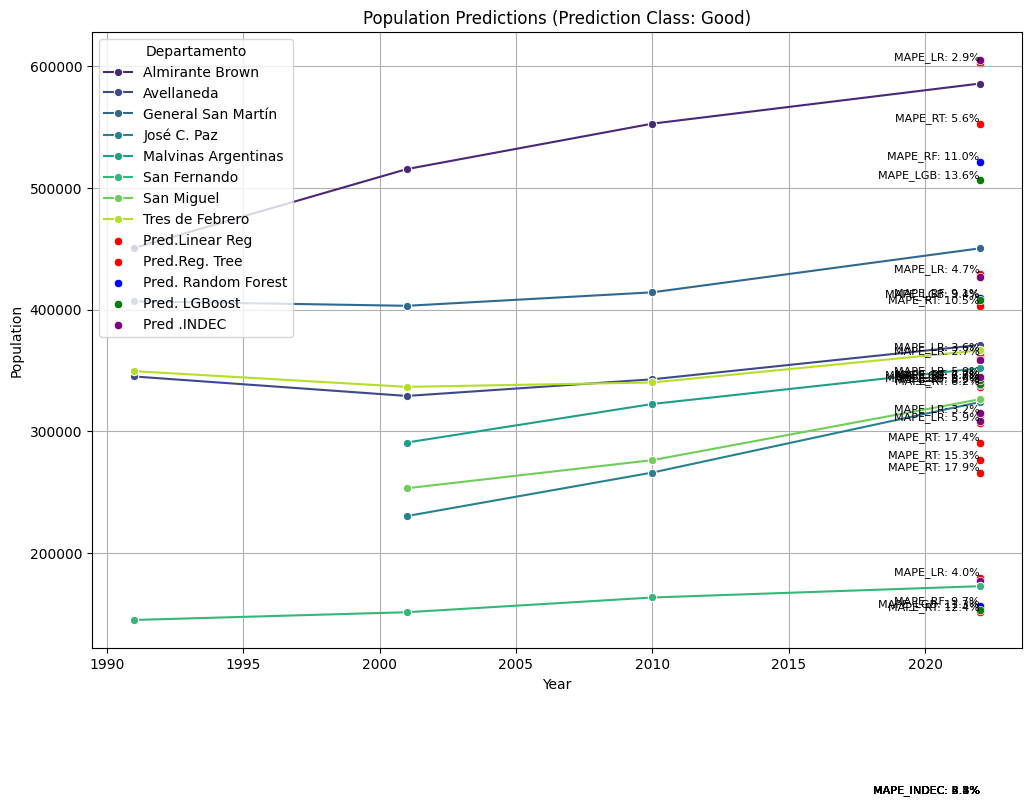

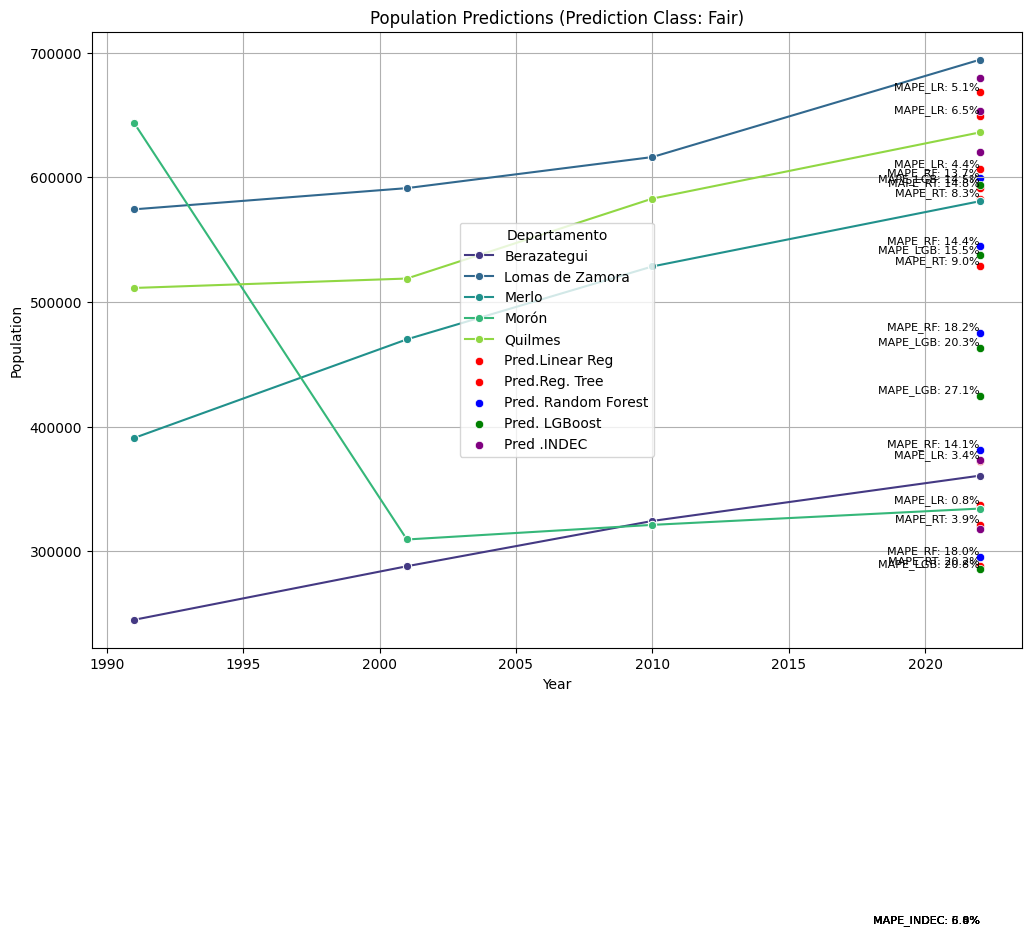

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


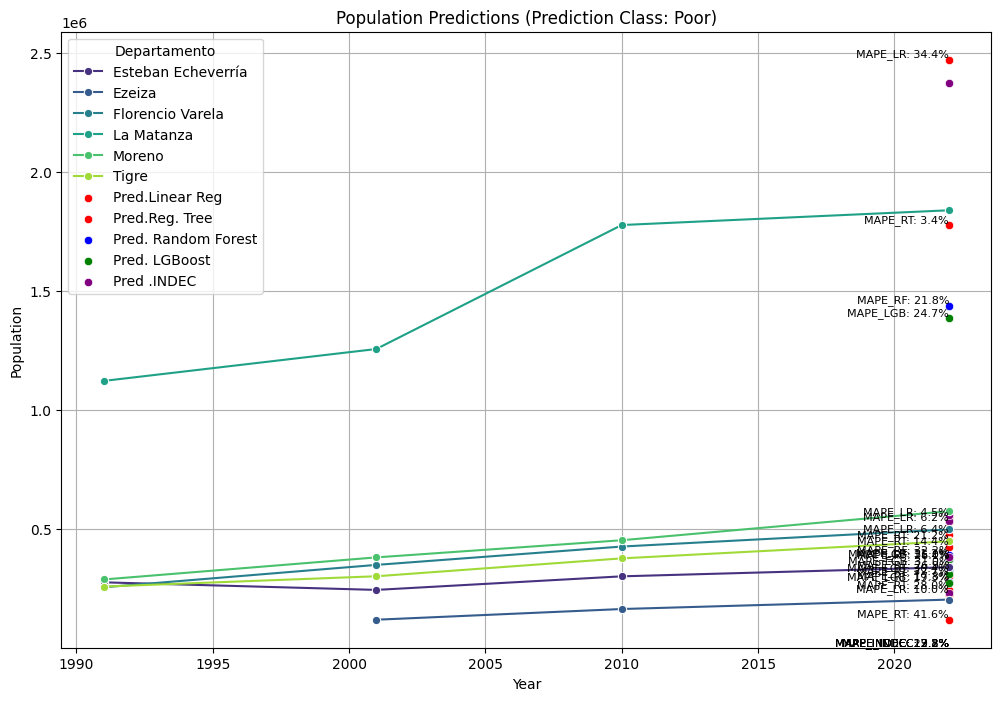

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


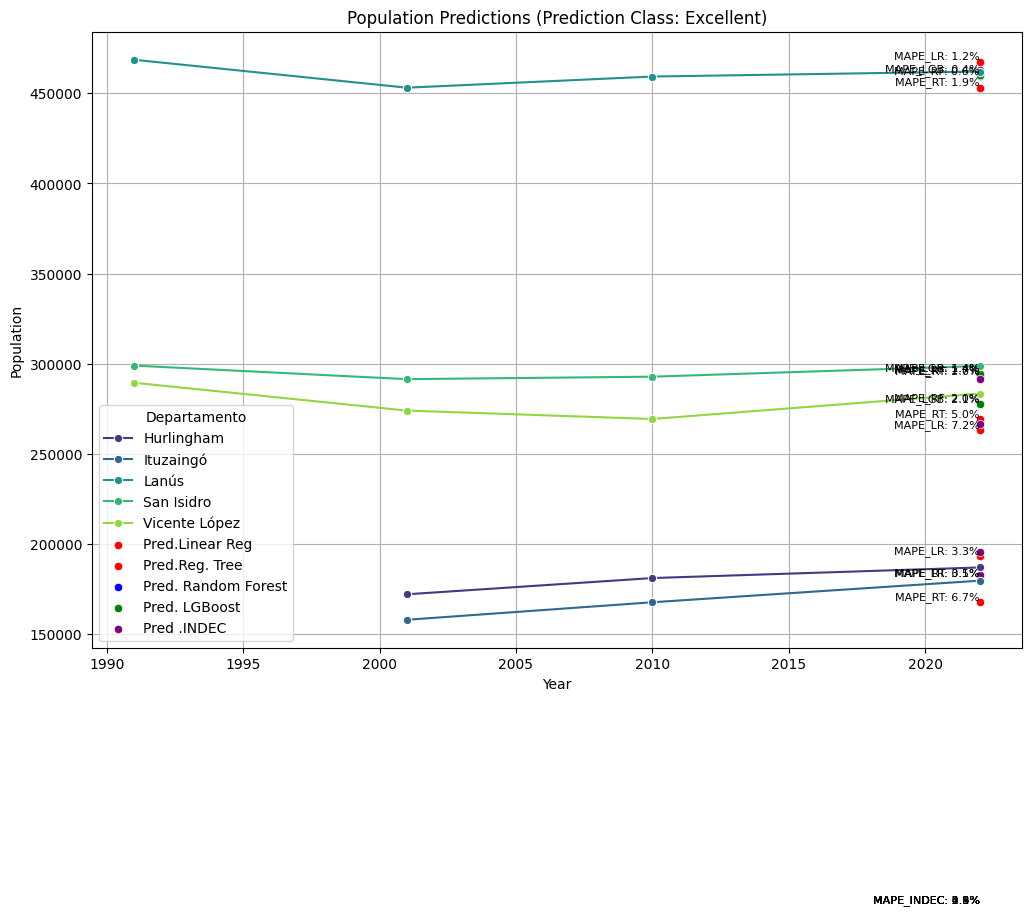

In [11]:
# Unique Prediction Classes
prediction_classes = merged_df['Prediction_Class'].unique()

# Create a plot for each Prediction Class
for prediction_class in prediction_classes:
    # Filter data for the current Prediction Class
    class_data = merged_df[merged_df['Prediction_Class'] == prediction_class]
    
    plt.figure(figsize=(12, 8))
    
    # Line plot of populations for 'Departamento' over time
    sns.lineplot(data=class_data, x='ano', y='pob', hue='Departamento', marker='o', linestyle='-', palette='viridis')
    
    # Scatter plot for predictions in 2022
    scatter_data = class_data[class_data['ano'] == 2022]
    
    # Add scatter plots for each prediction model
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_LR', color='red', label='Pred.Linear Reg')
    sns.scatterplot(data=scatter_data, x='ano', y='PredRegTree', color='red', label='Pred.Reg. Tree')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_RF', color='blue', label='Pred. Random Forest')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_LGB', color='green', label='Pred. LGBoost')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_INDEC', color='purple', label='Pred .INDEC')

    # Annotate MAPE values on scatter plot
    for index, row in scatter_data.iterrows():
        plt.text(row['ano'], row['Pred_LR'], f"MAPE_LR: {row['MAPE_LR']:.1f}%", fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['PredRegTree'], f"MAPE_RT: {row['MAPE_RT']:.1f}%", fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_RF'], f"MAPE_RF: {row['MAPE_RF']:.1f}%", fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_LGB'], f"MAPE_LGB: {row['MAPE_LGB']:.1f}%", fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['MAPE_Pred_INDEC'], f"MAPE_INDEC: {row['MAPE_Pred_INDEC']:.1f}%", fontsize=8, ha='right', va='bottom')

    # Plot configuration
    plt.title(f'Population Predictions (Prediction Class: {prediction_class})')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend(title='Departamento')
    plt.grid(True)
    plt.show()


#### PLOTTING ALL

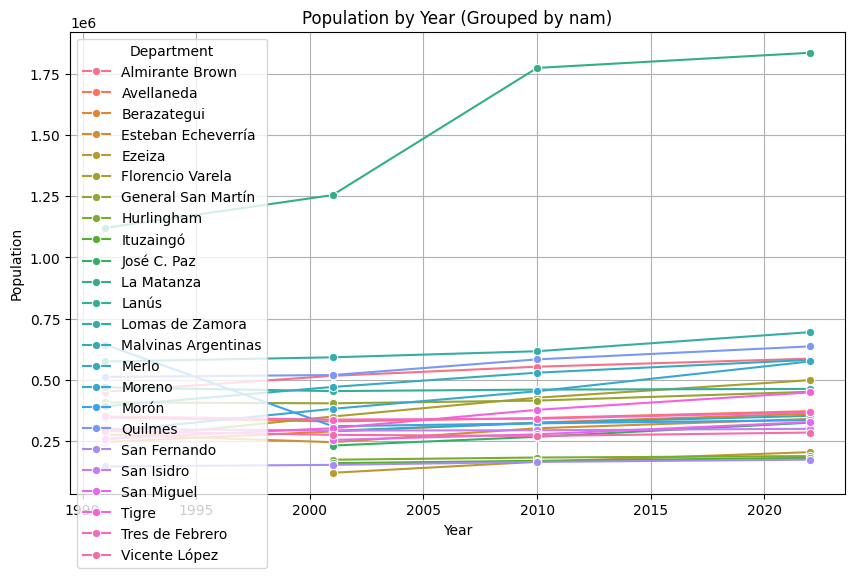

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=FullProy_df, x='ano', y='pob', hue='Departamento', marker='o', linestyle='-')
plt.title('Population by Year (Grouped by nam)')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(title='Department')
plt.grid(True)
plt.show()


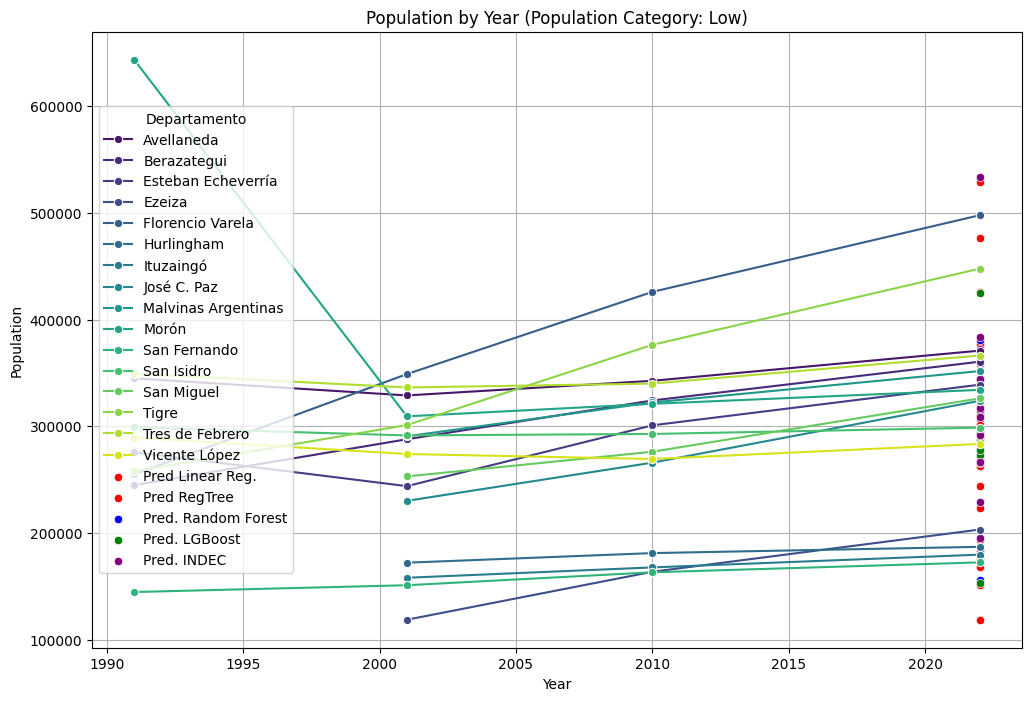

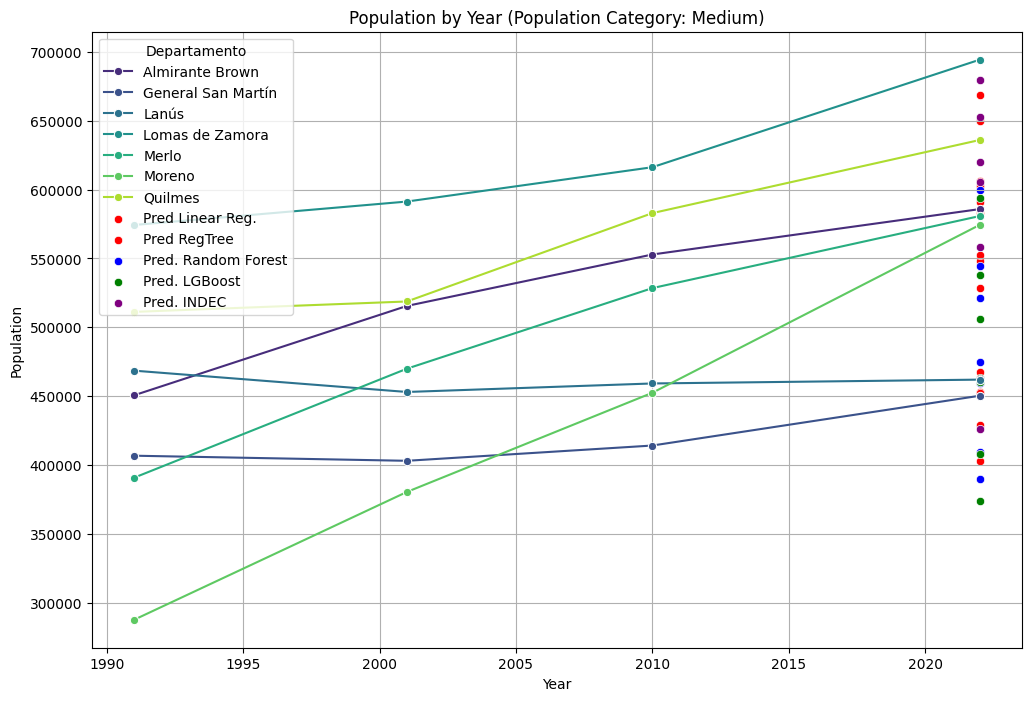

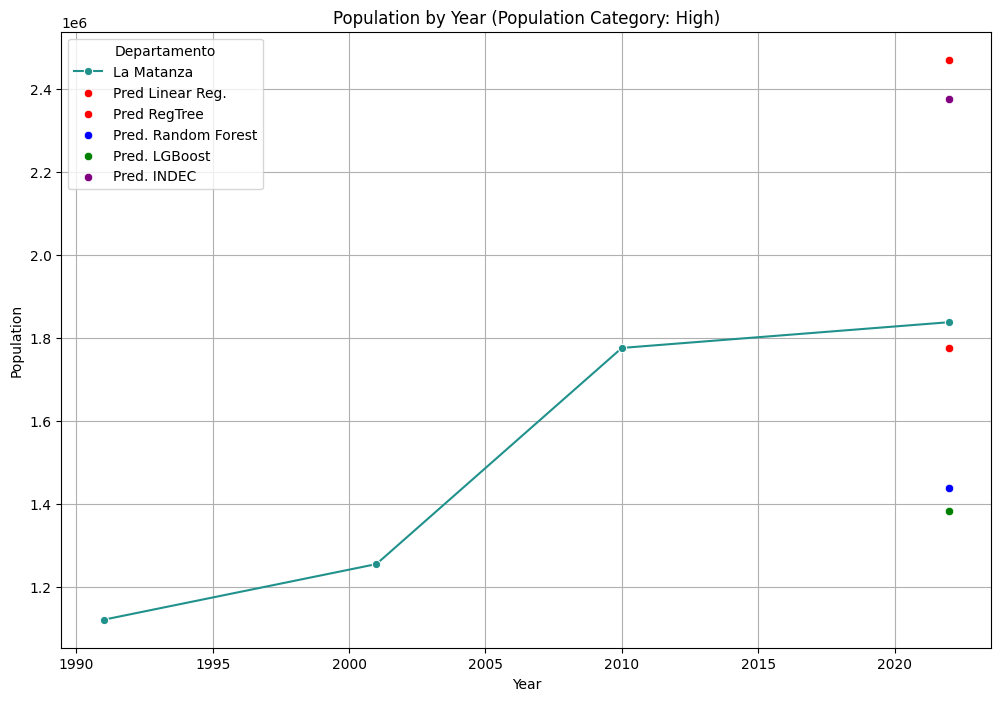

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


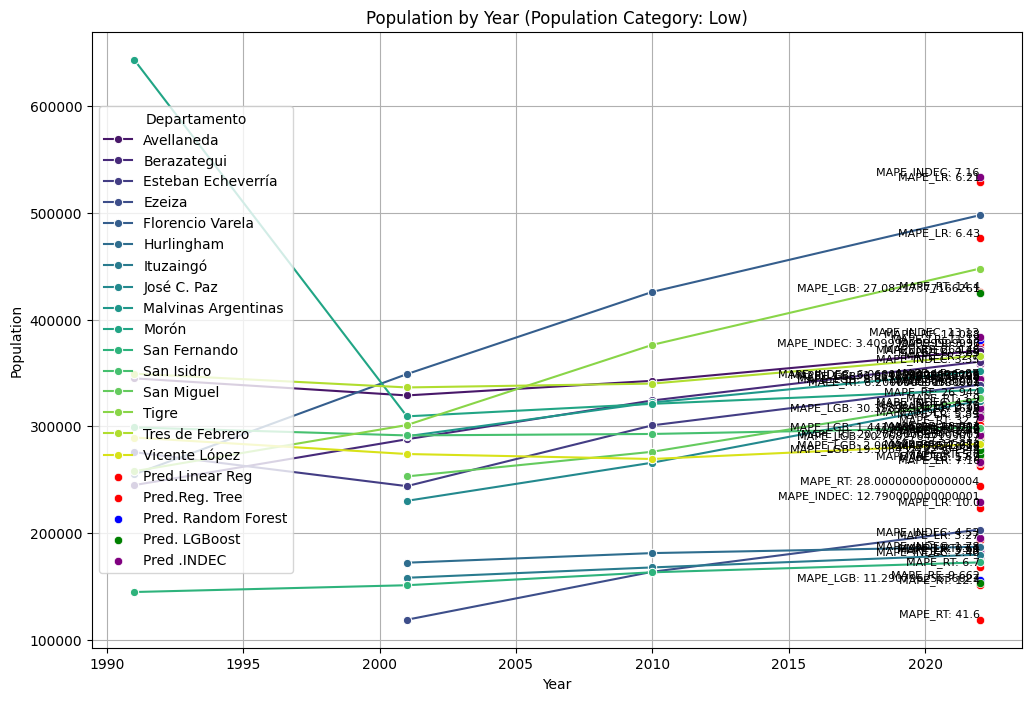

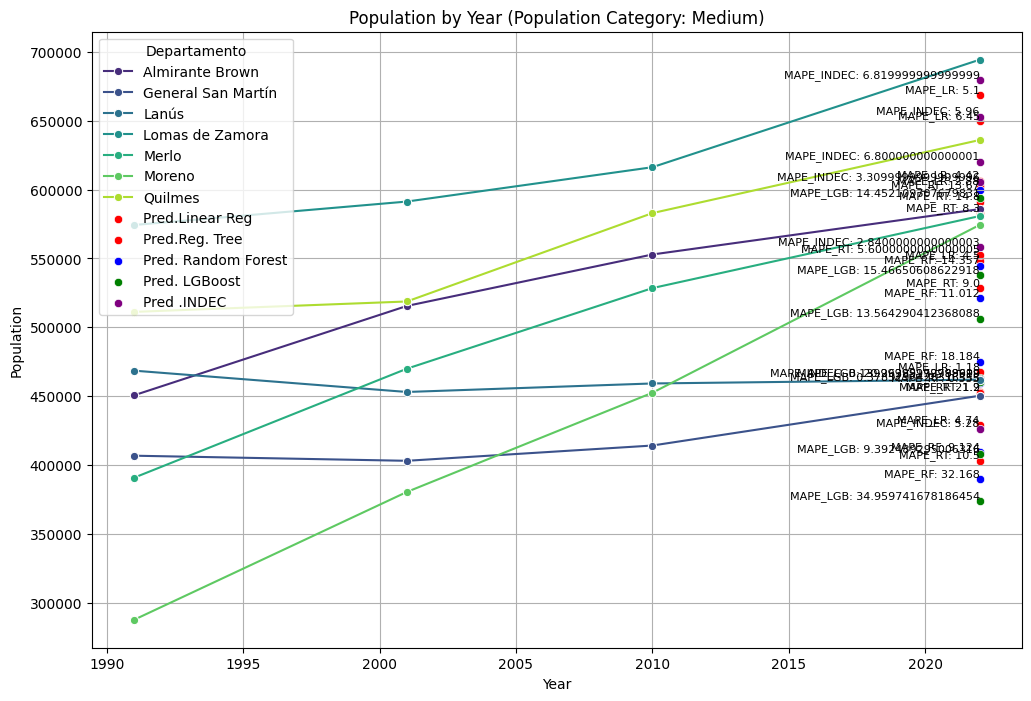

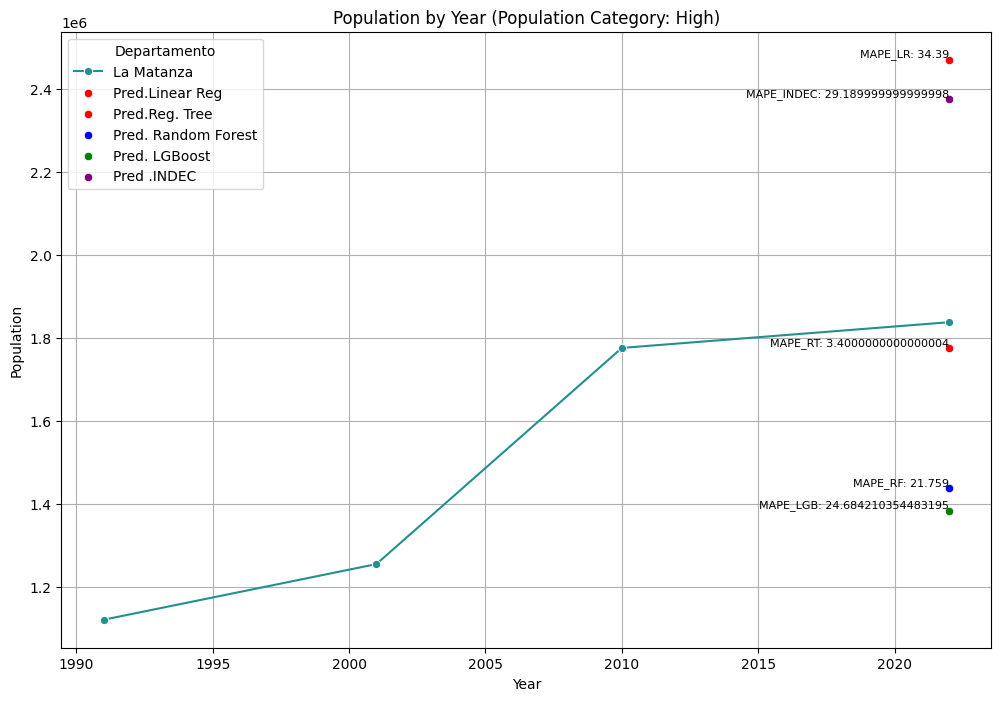

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the year 2001
year_2001_df = FullProy_df[FullProy_df['ano'] == 2001]

# Calculate the population for each department in the year 2001
department_pop_2001 = year_2001_df.groupby('Departamento')['pob'].first().reset_index()

# Define categories based on population values in 2001
def assign_category(population):
    if population < 350000:
        return 'Low'
    elif 350000 <= population < 1000000:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create a new column 'Population_Category'
department_pop_2001['Population_Category'] = department_pop_2001['pob'].apply(assign_category)

# Merge the population category back to the original DataFrame
FullProy_df = FullProy_df.merge(department_pop_2001[['Departamento', 'Population_Category']], on='Departamento', how='left', suffixes=('', '_y'))

# Plot each population category separately
for category in ['Low', 'Medium', 'High']:
    plt.figure(figsize=(12, 8))
    # Line plot
    sns.lineplot(data=FullProy_df[FullProy_df['Population_Category'] == category], x='ano', y='pob', hue='Departamento', marker='o', linestyle='-', palette='viridis')
    # Scatter plot for 2022
    sns.scatterplot(data=FullProy_df[(FullProy_df['Population_Category'] == category) & (FullProy_df['ano'] == 2022)], x='ano', y='Pred_LR', marker='o', color='red', label='Pred Linear Reg.')
    sns.scatterplot(data=FullProy_df[(FullProy_df['Population_Category'] == category) & (FullProy_df['ano'] == 2022)], x='ano', y='PredRegTree', marker='o', color='red', label='Pred RegTree')
    sns.scatterplot(data=FullProy_df[(FullProy_df['Population_Category'] == category) & (FullProy_df['ano'] == 2022)], x='ano', y='Pred_RF', marker='o', color='blue', label='Pred. Random Forest')
    sns.scatterplot(data=FullProy_df[(FullProy_df['Population_Category'] == category) & (FullProy_df['ano'] == 2022)], x='ano', y='Pred_LGB', marker='o', color='green', label='Pred. LGBoost')
    sns.scatterplot(data=FullProy_df[(FullProy_df['Population_Category'] == category) & (FullProy_df['ano'] == 2022)], x='ano', y='Pred_INDEC', marker='o', color='purple', label='Pred. INDEC')
    plt.title(f'Population by Year (Population Category: {category})')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend(title='Departamento')
    plt.grid(True)
    plt.show()
# Plot each population category separately
for category in ['Low', 'Medium', 'High']:
    plt.figure(figsize=(12, 8))
    # Line plot
    sns.lineplot(data=FullProy_df[FullProy_df['Population_Category'] == category], x='ano', y='pob', hue='Departamento', marker='o', linestyle='-', palette='viridis')
    # Scatter plot for 2022 with MAPE_LR
    scatter_data = FullProy_df[(FullProy_df['Population_Category'] == category) & (FullProy_df['ano'] == 2022)]
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_LR', marker='o', color='red', label='Pred.Linear Reg')
    sns.scatterplot(data=scatter_data, x='ano', y='PredRegTree', marker='o', color='red', label='Pred.Reg. Tree')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_RF', marker='o', color='blue', label='Pred. Random Forest')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_LGB', marker='o', color='green', label='Pred. LGBoost')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_INDEC', marker='o', color='purple', label='Pred .INDEC')
    for index, row in scatter_data.iterrows():
        plt.text(row['ano'], row['Pred_LR'], f"MAPE_LR: {row['MAPE_LR']}", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['PredRegTree'], f"MAPE_RT: {row['MAPE_RT']}", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_RF'], f"MAPE_RF: {row['MAPE_RF']}", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_LGB'], f"MAPE_LGB: {row['MAPE_LGB']}", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_INDEC'], f"MAPE_INDEC: {row['MAPE_Pred_INDEC']}", color='black', fontsize=8, ha='right', va='bottom')
    plt.title(f'Population by Year (Population Category: {category})')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend(title='Departamento')
    plt.grid(True)
    plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


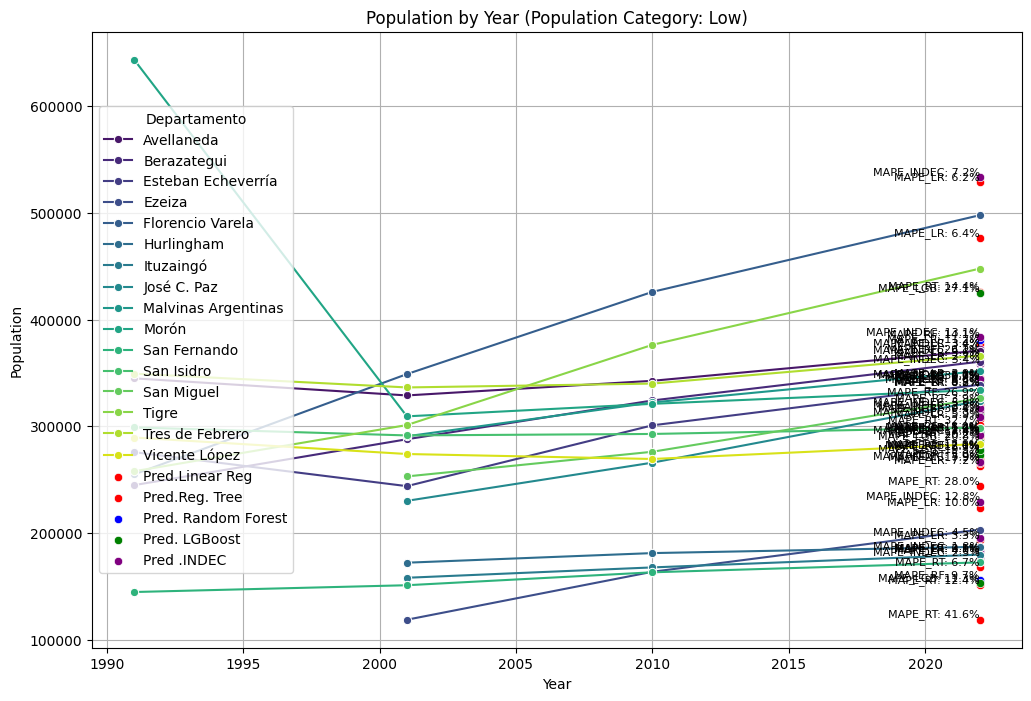

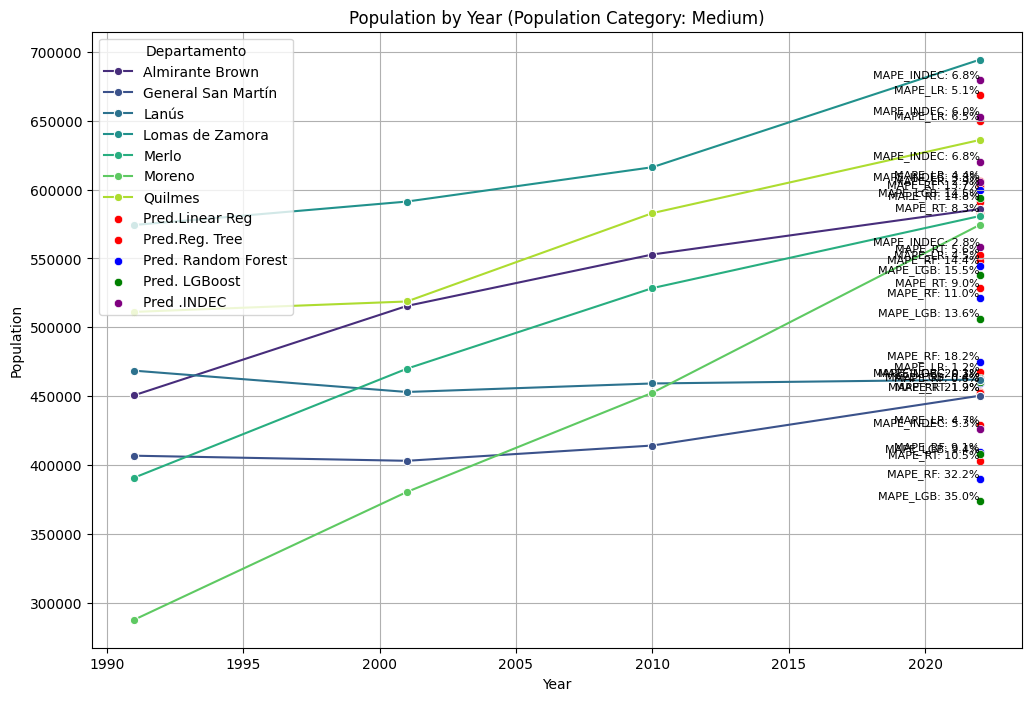

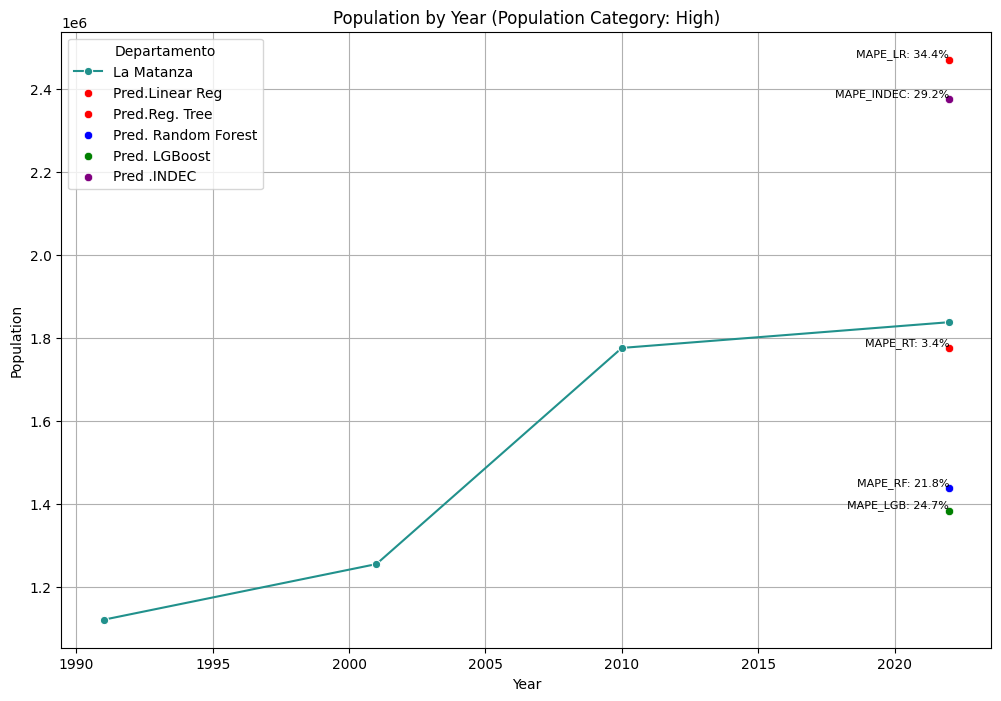

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the year 2001
year_2001_df = FullProy_df[FullProy_df['ano'] == 2001]

# Calculate the population for each department in the year 2001
department_pop_2001 = year_2001_df.groupby('Departamento')['pob'].first().reset_index()

# Define categories based on population values in 2001
def assign_category(population):
    if population < 350000:
        return 'Low'
    elif 350000 <= population < 1000000:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create a new column 'Population_Category'
department_pop_2001['Population_Category'] = department_pop_2001['pob'].apply(assign_category)

# Merge the population category back to the original DataFrame
FullProy_df = FullProy_df.merge(department_pop_2001[['Departamento', 'Population_Category']], on='Departamento', how='left', suffixes=('', '_y'))

# Plot each population category separately
for category in ['Low', 'Medium', 'High']:
    plt.figure(figsize=(12, 8))
    # Line plot
    sns.lineplot(data=FullProy_df[FullProy_df['Population_Category'] == category], x='ano', y='pob', hue='Departamento', marker='o', linestyle='-', palette='viridis')
    # Scatter plot for 2022 with MAPE_LR
    scatter_data = FullProy_df[(FullProy_df['Population_Category'] == category) & (FullProy_df['ano'] == 2022)]
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_LR', marker='o', color='red', label='Pred.Linear Reg')
    sns.scatterplot(data=scatter_data, x='ano', y='PredRegTree', marker='o', color='red', label='Pred.Reg. Tree')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_RF', marker='o', color='blue', label='Pred. Random Forest')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_LGB', marker='o', color='green', label='Pred. LGBoost')
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_INDEC', marker='o', color='purple', label='Pred .INDEC')
    for index, row in scatter_data.iterrows():
        plt.text(row['ano'], row['Pred_LR'], f"MAPE_LR: {row['MAPE_LR']:.1f}%", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['PredRegTree'], f"MAPE_RT: {row['MAPE_RT']:.1f}%", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_RF'], f"MAPE_RF: {row['MAPE_RF']:.1f}%", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_LGB'], f"MAPE_LGB: {row['MAPE_LGB']:.1f}%", color='black', fontsize=8, ha='right', va='bottom')
        plt.text(row['ano'], row['Pred_INDEC'], f"MAPE_INDEC: {row['MAPE_Pred_INDEC']:.1f}%", color='black', fontsize=8, ha='right', va='bottom')

    plt.title(f'Population by Year (Population Category: {category})')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend(title='Departamento')
    plt.grid(True)
    plt.show()

#### Plotting 2nd OPtion

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


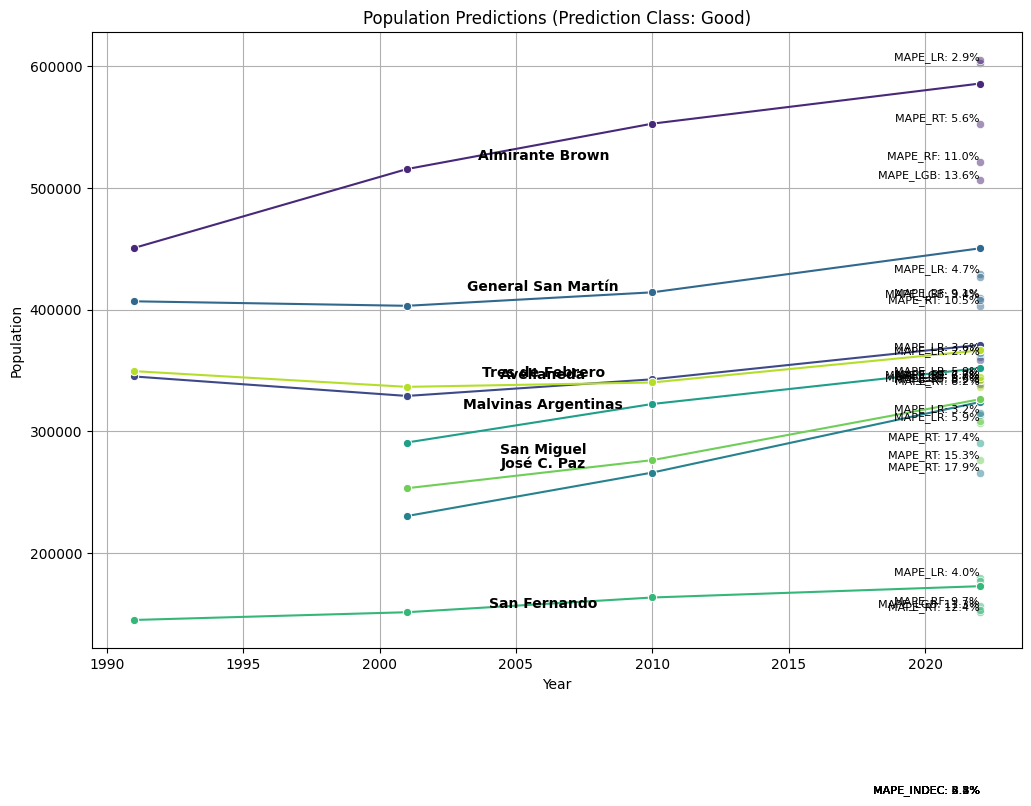

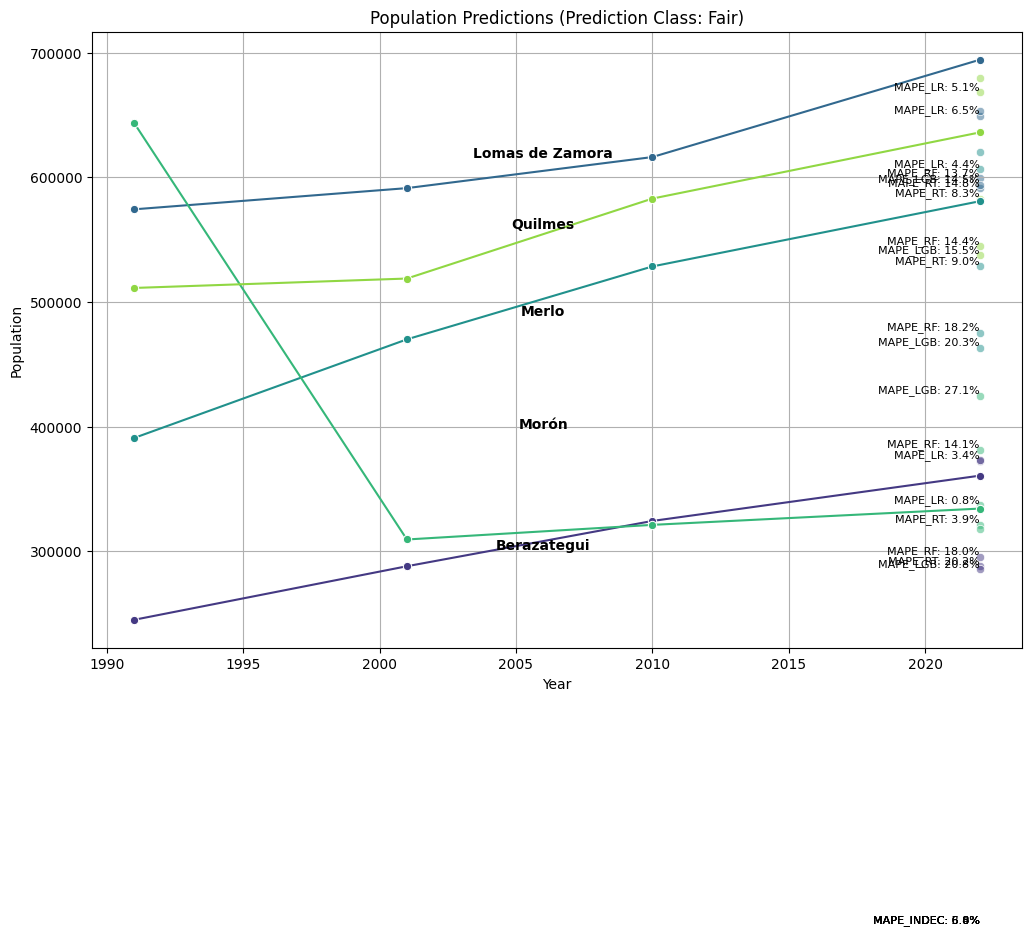

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


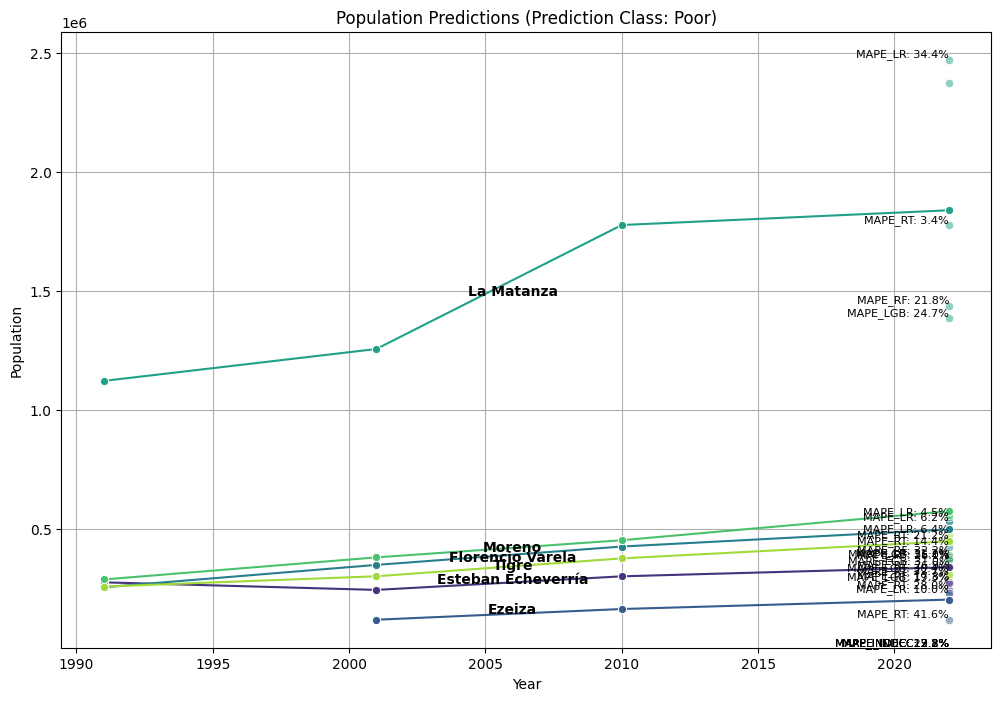

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


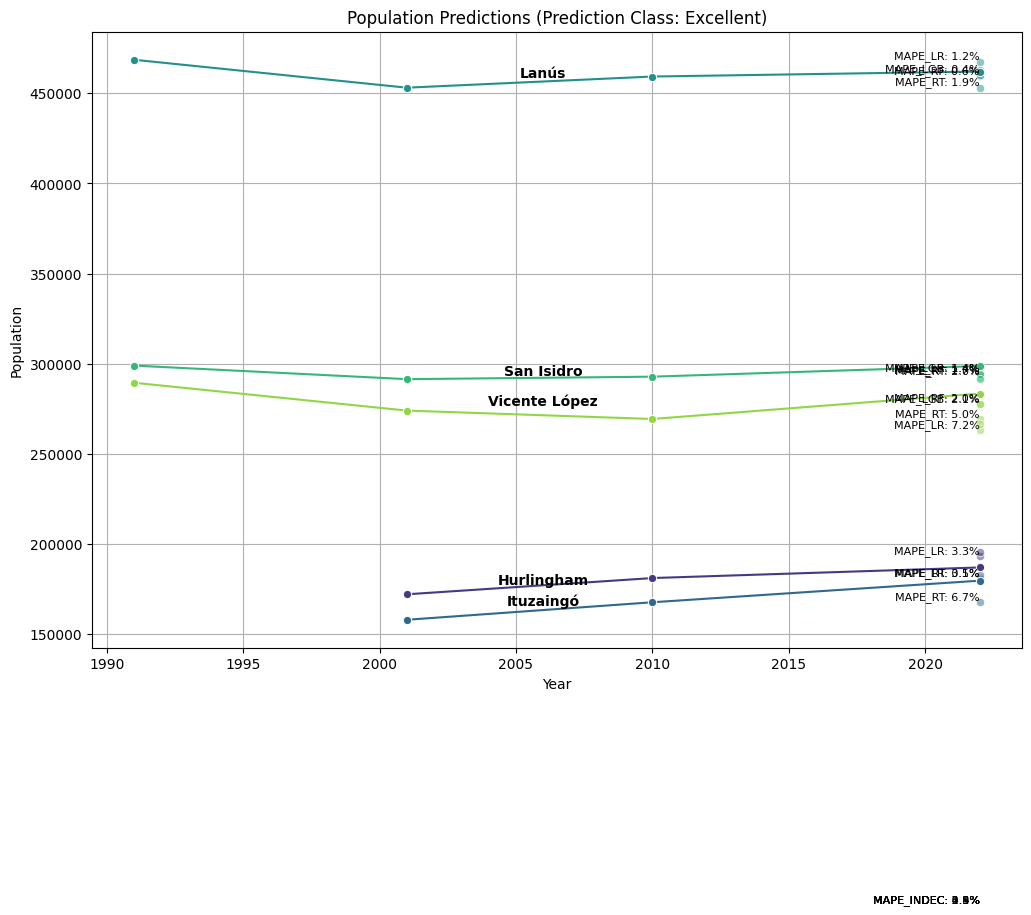

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Unique Prediction Classes
prediction_classes = merged_df['Prediction_Class'].unique()

# Create a plot for each Prediction Class
for prediction_class in prediction_classes:
    # Filter data for the current Prediction Class
    class_data = merged_df[merged_df['Prediction_Class'] == prediction_class]
    
    plt.figure(figsize=(12, 8))
    
    # Line plot of populations for 'Departamento' over time, without the legend
    lineplot = sns.lineplot(
        data=class_data,
        x='ano',
        y='pob',
        hue='Departamento',
        marker='o',
        linestyle='-',
        palette='viridis',
        legend=False,  # Exclude the legend
    )
    
    # Get unique 'Departamento' values
    departamentos = class_data['Departamento'].unique()
    
    # Find the midpoint of the x-axis for annotation
    midpoint = np.mean(class_data['ano'].unique())  # Calculate midpoint

    for departamento in departamentos:
        # Calculate y-coordinate for annotation (mean of 'pob' for this 'Departamento')
        data_subset = class_data[class_data['Departamento'] == departamento]
        y_mid = data_subset['pob'].mean()
        
        # Annotate with 'Departamento' at the center
        plt.text(
            midpoint,
            y_mid,
            departamento,
            fontsize=10,
            color='black',
            ha='center',
            va='center',
            fontweight='bold'
        )
    
    # Scatter plot for predictions in 2022
    scatter_data = class_data[class_data['ano'] == 2022]
    
    # Faded scatter plot colors
    alpha_value = 0.5  # Fade level
    
    # Define base colors for each 'Departamento'
    line_palette = sns.color_palette("viridis", len(departamentos))
    base_colors = {departamentos[i]: line_palette[i] for i in range(len(departamentos))}
    
    for departamento in scatter_data['Departamento'].unique():
        base_color = base_colors[departamento]
        faded_color = mcolors.to_rgba(base_color, alpha=alpha_value)
        
        # Scatter plots for each prediction model, with labels
        sns.scatterplot(
            data=scatter_data[scatter_data['Departamento'] == departamento],
            x='ano',
            y='Pred_LR',
            color=faded_color
            
        )
        sns.scatterplot(
            data=scatter_data[scatter_data['Departamento'] == departamento],
            x='ano',
            y='PredRegTree',
            color=faded_color
            
        )
        sns.scatterplot(
            data=scatter_data[scatter_data['Departamento'] == departamento],
            x='ano',
            y='Pred_RF',
            color=faded_color
            
        )
        sns.scatterplot(
            data=scatter_data[scatter_data['Departamento'] == departamento],
            x='ano',
            y='Pred_LGB',
            color=faded_color
            
        )
        sns.scatterplot(
            data=scatter_data[scatter_data['Departamento'] == departamento],
            x='ano',
            y='Pred_INDEC',
            color=faded_color
           
        )
    
    # Annotate MAPE values on scatter plots
    for index, row in scatter_data.iterrows():
        plt.text(
            row['ano'], 
            row['Pred_LR'], 
            f"MAPE_LR: {row['MAPE_LR']:.1f}%", 
            fontsize=8, 
            ha='right', 
            va='bottom'
        )
        plt.text(
            row['ano'], 
            row['PredRegTree'], 
            f"MAPE_RT: {row['MAPE_RT']:.1f}%", 
            fontsize=8, 
            ha='right', 
            va='bottom'
        )
        plt.text(
            row['ano'], 
            row['Pred_RF'], 
            f"MAPE_RF: {row['MAPE_RF']:.1f}%", 
            fontsize=8, 
            ha='right', 
            va='bottom'
        )
        plt.text(
            row['ano'], 
            row['Pred_LGB'], 
            f"MAPE_LGB: {row['MAPE_LGB']:.1f}%", 
            fontsize=8, 
            ha='right', 
            va='bottom'
        )
        plt.text(
            row['ano'], 
            row['MAPE_Pred_INDEC'], 
            f"MAPE_INDEC: {row['MAPE_Pred_INDEC']:.1f}%", 
            fontsize=8, 
            ha='right', 
            va='bottom'
        )

    # Plot configuration
    plt.title(f'Population Predictions (Prediction Class: {prediction_class})')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.grid(True)
    plt.show()


#### 3rd option


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


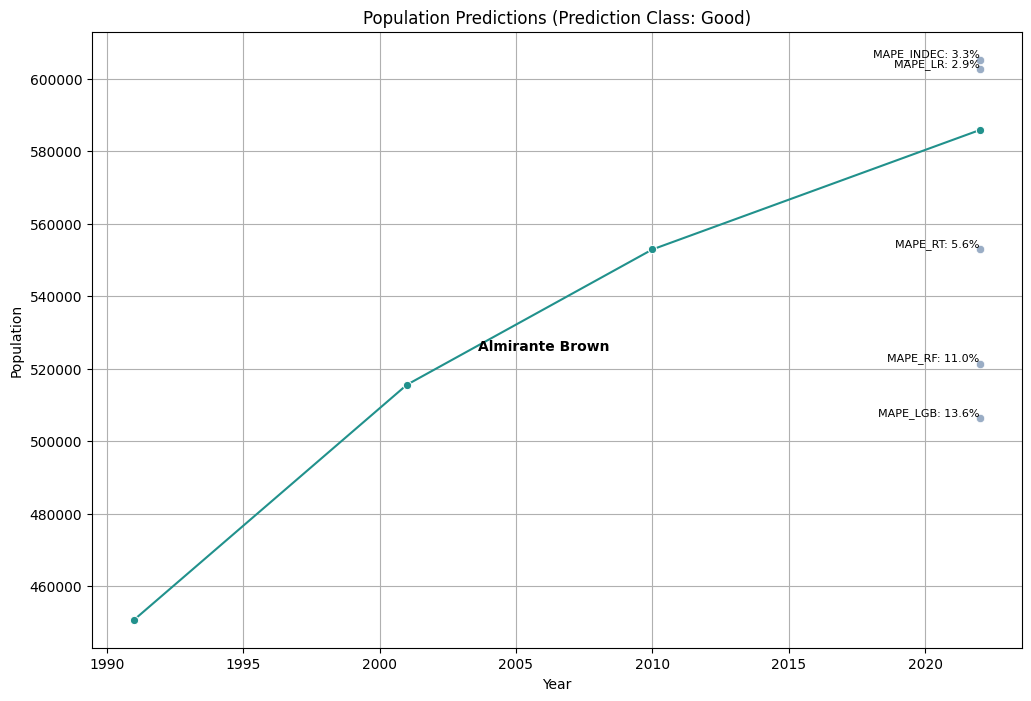

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


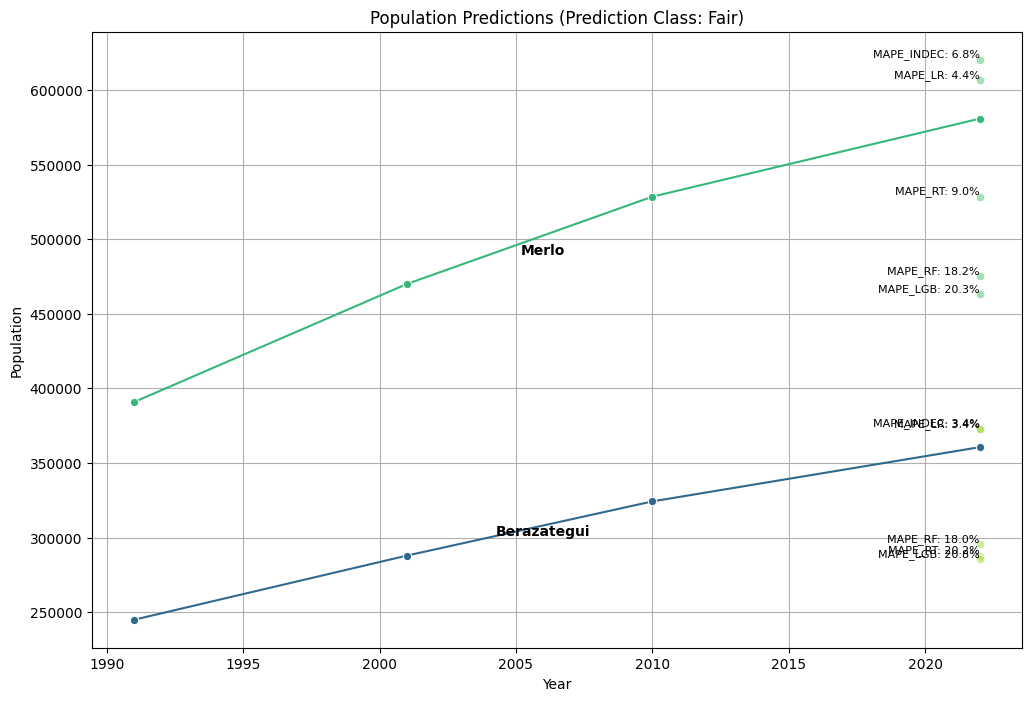

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


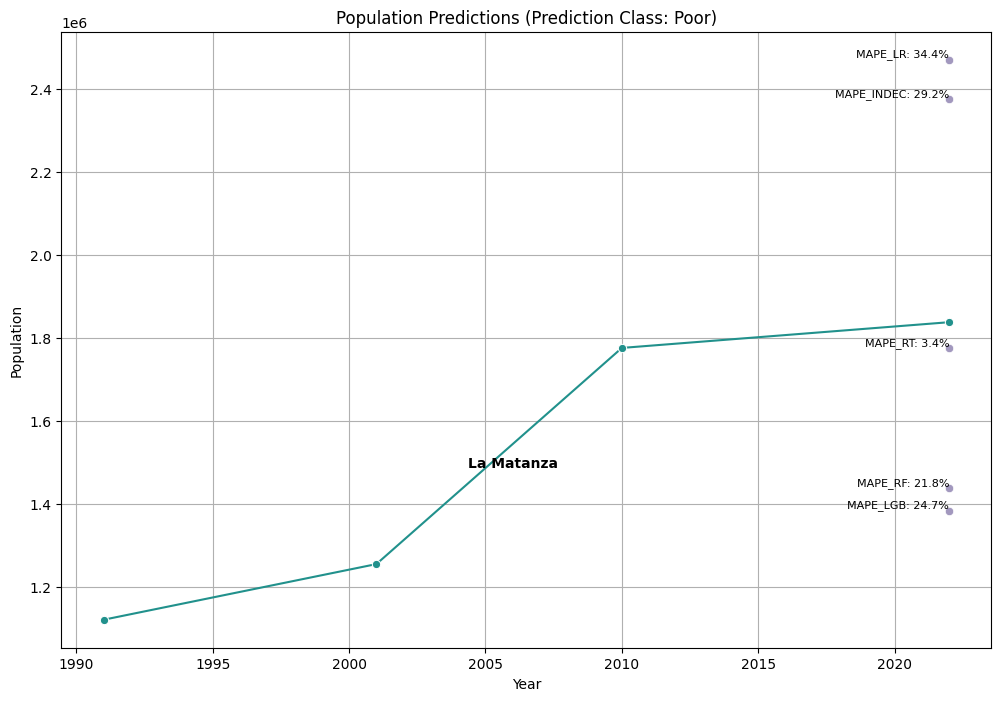

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


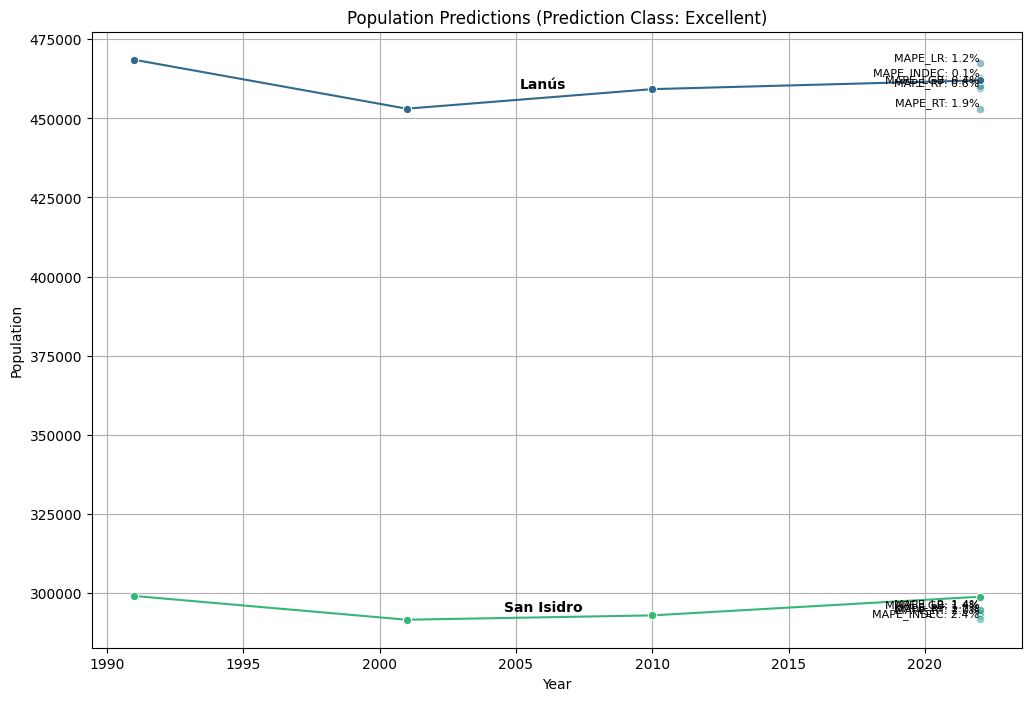

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# List of 'Departamentos' to include
selected_departamentos = ['La Matanza', 'Almirante Brown', 'Lanús','San Isidro','Merlo','Berazategui']  # Example list

# Filter the merged DataFrame to include only selected 'Departamentos'
filtered_df = merged_df[merged_df['Departamento'].isin(selected_departamentos)]

# Get unique Prediction Classes
prediction_classes = filtered_df['Prediction_Class'].unique()

# Create a plot for each Prediction Class
for prediction_class in prediction_classes:
    # Filter data for the current Prediction Class
    class_data = filtered_df[filtered_df['Prediction_Class'] == prediction_class]
    
    plt.figure(figsize=(12, 8))
    
    # Line plot of populations for 'Departamento' over time
    sns.lineplot(
        data=class_data,
        x='ano',
        y='pob',
        hue='Departamento',
        marker='o',
        linestyle='-',
        palette='viridis',
        legend=False,  # No legend
    )
    
    # Annotate the center with 'Departamento'
    midpoint = np.mean(class_data['ano'].unique())  # Midpoint for annotation
    
    for departamento in selected_departamentos:
        # Find the average population to position the annotation
        y_mid = class_data[class_data['Departamento'] == departamento]['pob'].mean()
        
        plt.text(
            midpoint,
            y_mid,
            departamento,
            fontsize=10,
            color='black',
            ha='center',  # Center horizontally
            va='center',  # Center vertically
            fontweight='bold'  # Bold text
        )
    
    # Scatter plot for predictions in 2022
    scatter_data = class_data[class_data['ano'] == 2022]
    
    # Faded scatter plot colors
    alpha_value = 0.5  # Level of fade
    
    # Get base colors for each 'Departamento' from the line plot palette
    base_colors = sns.color_palette("viridis", len(selected_departamentos))
    color_dict = {selected_departamentos[i]: base_colors[i] for i in range(len(selected_departamentos))}
    
    # Scatter plots with fade for each prediction model
    for departamento in selected_departamentos:
        if departamento in scatter_data['Departamento'].values:
            base_color = color_dict[departamento]
            faded_color = mcolors.to_rgba(base_color, alpha=alpha_value)  # Apply fade
            
            sns.scatterplot(
                data=scatter_data[scatter_data['Departamento'] == departamento],
                x='ano',
                y='Pred_LR',
                color=faded_color
            
            )
            sns.scatterplot(
                data=scatter_data[scatter_data['Departamento'] == departamento],
                x='ano',
                y='PredRegTree',
                color=faded_color
               
            )
            sns.scatterplot(
                data=scatter_data[scatter_data['Departamento'] == departamento],
                x='ano',
                y='Pred_RF',
                color=faded_color
                
            )
            sns.scatterplot(
                data=scatter_data[scatter_data['Departamento'] == departamento],
                x='ano',
                y='Pred_LGB',
                color=faded_color
                
            )
            sns.scatterplot(
                data=scatter_data[scatter_data['Departamento'] == departamento],
                x='ano',
                y='Pred_INDEC',
                color=faded_color
            
            )

    # Annotate with MAPE values
    for index, row in scatter_data.iterrows():
        if 'Pred_LR' in row.index:
            plt.text(
                row['ano'], 
                row['Pred_LR'], 
                f"MAPE_LR: {row['MAPE_LR']:.1f}%", 
                fontsize=8, 
                ha='right', 
                va='bottom'
            )
        if 'PredRegTree' in row.index:
            plt.text(
                row['ano'], 
                row['PredRegTree'], 
                f"MAPE_RT: {row['MAPE_RT']:.1f}%", 
                fontsize=8,
                ha='right', 
                va='bottom'
            )
        if 'Pred_RF' in row.index:
            plt.text(
                row['ano'], 
                row['Pred_RF'], 
                f"MAPE_RF: {row['MAPE_RF']:.1f}%", 
                fontsize=8, 
                ha='right', 
                va='bottom'
            )
        if 'Pred_LGB' in row.index:
            plt.text(
                row['ano'], 
                row['Pred_LGB'], 
                f"MAPE_LGB: {row['MAPE_LGB']:.1f}%", 
                fontsize=8, 
                ha='right', 
                va='bottom'
            )
        if 'MAPE_Pred_INDEC' in row.index:
            plt.text(
                row['ano'], 
                row['Pred_INDEC'], 
                f"MAPE_INDEC: {row['MAPE_Pred_INDEC']:.1f}%", 
                fontsize=8, 
                ha='right', 
                va='bottom'
            )

    # Plot configuration
    plt.title(f'Population Predictions (Prediction Class: {prediction_class})')
    plt.xlabel("Year")
    plt.ylabel("Population")
    plt.grid(True)
    plt.show()


## ANALISIS PREDICIONTES SEGUN CV or GROTH RATIO
#### Donde se predice mejor

In [17]:
### READING GROWTH RATIO VARIATION fro CSV by CITY

# Read the CSV file into a DataFrame
Growth_ratios_df = pd.read_csv('C:/Users/Fer/ITBA_TFI/datasets/city_growth_statistics.csv')
gratios_df=Growth_ratios_df.drop(columns='Unnamed: 0')
gratios_df=gratios_df.rename(columns={'nam': 'Departamento'})
# Display the DataFrame to check the content
print(gratios_df.head())

         Departamento  Standard Deviation  Coefficient of Variation       Mean
0     Almirante Brown            4.542866                 49.396878   9.196667
1          Avellaneda            6.586858                254.318847   2.590000
2         Berazategui            3.328879                 24.133968  13.793333
3  Esteban Echeverría           17.878619                219.190267   8.156667
4              Ezeiza            9.652008                 31.150581  30.985000


In [18]:
###Prediction and errors dataset
full_df.head()
rows_2022 = full_df[full_df['ano'] == 2022]
rows_2022.tail()


,Departamento,ano,pob,Pred_LR,MAPE_LR,PredRegTree,MAPE_RT,Pred_RF,MAPE_RF,Pred_LGB,MAPE_LGB,Pred_INDEC,MAPE_Pred_INDEC,Prediction_Class
77,San Isidro,2022,298777.0,294708,1.36,292878,2.0,293647.0,1.717,294469.0,1.441990,291704.0,2.37,Excellent
80,San Miguel,2022,326215.0,306995,5.89,276190,15.3,NaN,NaN,NaN,NaN,308784.0,5.34,Good
84,Tigre,2022,447785.0,476591,6.43,301223,32.7,327135.0,26.944,311842.0,30.358989,NaN,NaN,Poor
88,Tres de Febrero,2022,366377.0,344876,5.87,336467,8.2,341817.0,6.703,341971.0,6.661353,344172.0,6.06,Good
93,Vicente López,2022,283510.0,263204,7.16,269420,5.0,277881.0,1.986,277669.0,2.060245,266880.0,5.87,Excellent


In [19]:
# Merge rows_2022 with gratios_df based on the 'Departamento' column
Mega_df = rows_2022.merge(gratios_df, on='Departamento', how='inner')

# Display the merged DataFrame
print(Mega_df)


           Departamento   ano        pob  Pred_LR  MAPE_LR  PredRegTree  \
0       Almirante Brown  2022   585852.0   602696     2.88       552902   
1            Avellaneda  2022   370939.0   360939     2.70       342677   
2           Berazategui  2022   360582.0   372685     3.36       287913   
3    Esteban Echeverría  2022   339030.0   376939    11.18       243974   
4                Ezeiza  2022   203283.0   223608    10.00       118807   
5      Florencio Varela  2022   497818.0   528718     6.21       426005   
6    General San Martín  2022   450335.0   428981     4.74       403107   
7            Hurlingham  2022   187122.0   193235     3.27       181241   
8             Ituzaingó  2022   179788.0   180761     0.54       167824   
9           José C. Paz  2022   323918.0   313678     3.16       265981   
10           La Matanza  2022  1837774.0  2469853    34.39      1775816   
11                Lanús  2022   462051.0   467504     1.18       453082   
12      Lomas de Zamora  

##### Analizing according to prediction class

C:\Users\Fer\AppData\Local\Temp\ipykernel_19924\1506397620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Mean'] = filtered_df.groupby('Departamento')['pob'].transform('mean')


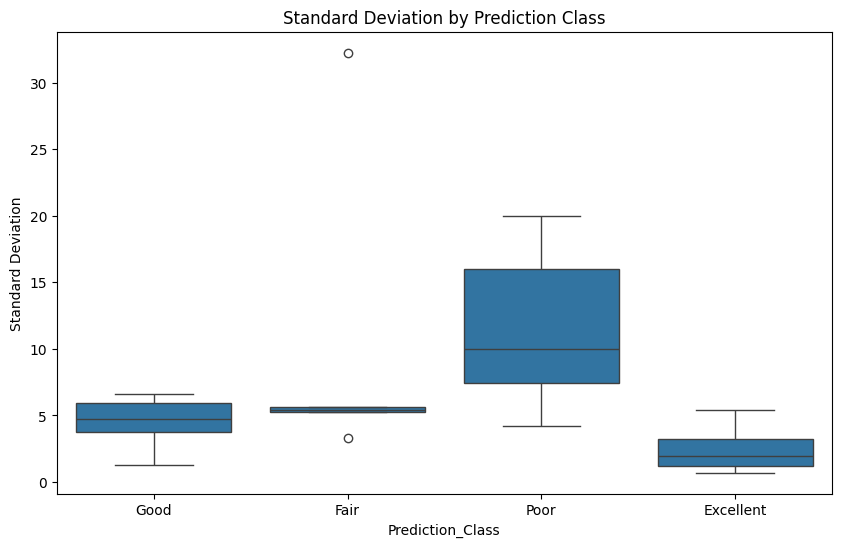

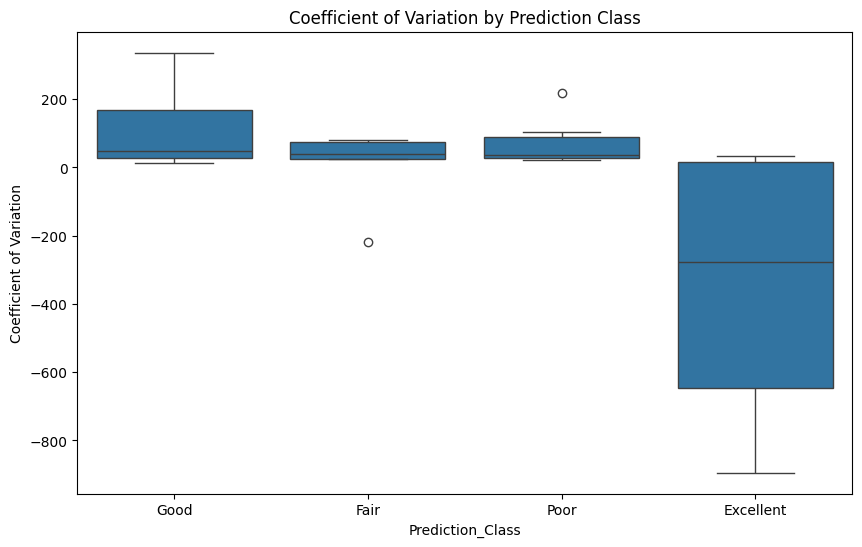

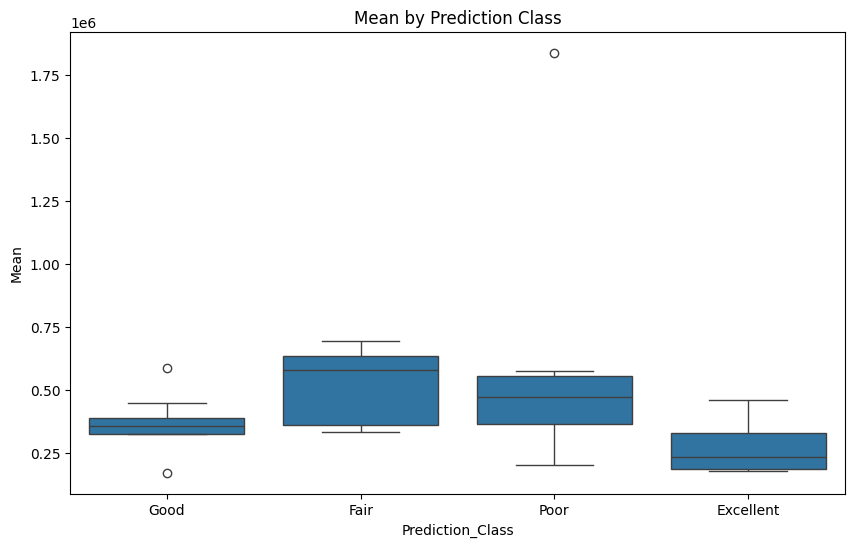

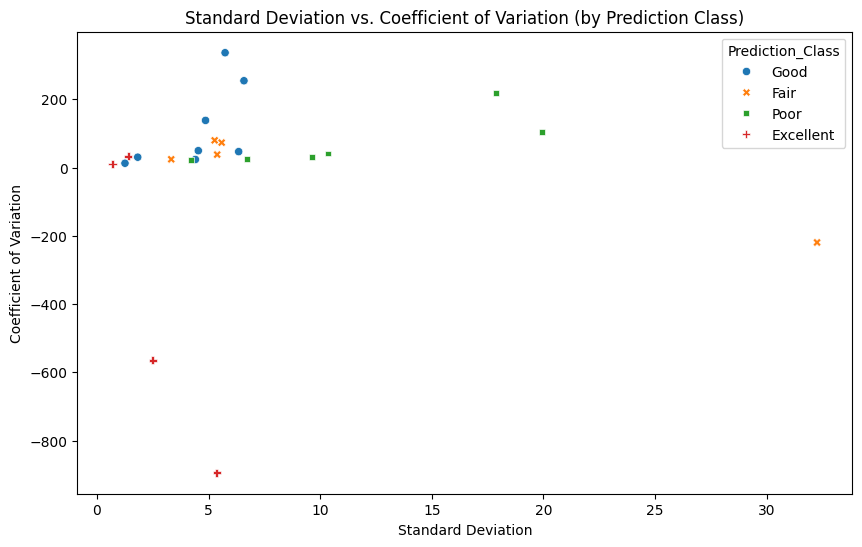

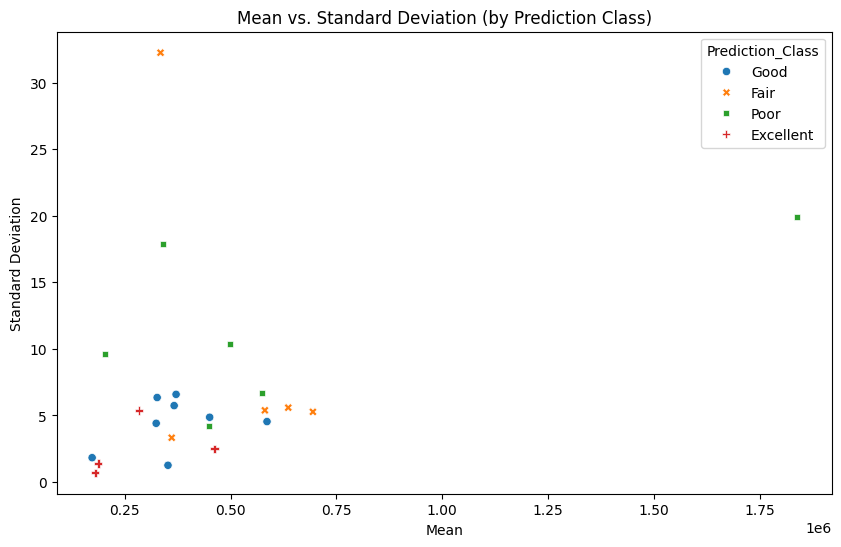

Summary Statistics by Prediction Class:
                 Standard Deviation                                            \
                              count       mean        std       min       25%   
Prediction_Class                                                                
Excellent                       4.0   2.491891   2.054192  0.700036  1.225062   
Fair                            5.0  10.366053  12.267986  3.328879  5.274328   
Good                            8.0   4.448463   1.966851  1.258650  3.766591   
Poor                            6.0  11.462465   6.204274  4.224894  7.445565   

                                                  Coefficient of Variation  \
                        50%        75%        max                    count   
Prediction_Class                                                             
Excellent          1.951139   3.217967   5.365249                      4.0   
Fair               5.386746   5.589225  32.251090                      5.0   
Go

In [20]:
# Drop rows where 'Departamento' is 'San Isidro'
filtered_df = Mega_df[Mega_df['Departamento'] != 'San Isidro']

# Calculate the mean of the 'pob' column
filtered_df['Mean'] = filtered_df.groupby('Departamento')['pob'].transform('mean')

# Box plot of standard deviation by prediction class
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='Prediction_Class', y='Standard Deviation')
plt.title('Standard Deviation by Prediction Class')
plt.show()

# Box plot of CV by prediction class
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='Prediction_Class', y='Coefficient of Variation')
plt.title('Coefficient of Variation by Prediction Class')
plt.show()

# Box plot of mean by prediction class
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='Prediction_Class', y='Mean')
plt.title('Mean by Prediction Class')
plt.show()

# Scatter plot of standard deviation vs. CV, colored by prediction class
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='Standard Deviation', y='Coefficient of Variation', hue='Prediction_Class', style='Prediction_Class')
plt.title('Standard Deviation vs. Coefficient of Variation (by Prediction Class)')
plt.show()

# Scatter plot of mean vs. standard deviation, colored by prediction class
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='Mean', y='Standard Deviation', hue='Prediction_Class', style='Prediction_Class')
plt.title('Mean vs. Standard Deviation (by Prediction Class)')
plt.show()

# Calculate summary statistics
summary_stats = filtered_df.groupby('Prediction_Class')[['Standard Deviation', 'Coefficient of Variation', 'Mean']].describe()
print("Summary Statistics by Prediction Class:")
print(summary_stats)



En general a menor media y mejor st dev mas aciertan.. es lógico...

#### Analize only the prediction made by INDEC


In [21]:

# Define a categorization function for MAPE
def categorize_mape(mape):
    if pd.isnull(mape):
        return 'No Data'
    elif mape < 5:
        return 'Excellent'
    elif 5 <= mape < 10:
        return 'Good'
    elif 10 <= mape < 20:
        return 'Fair'
    else:
        return 'Poor'

# Apply the categorization function to create a new column 'MAPE_Category'
rows_2022['MAPE_Category'] = rows_2022['MAPE_Pred_INDEC'].apply(categorize_mape)

# Display the DataFrame with the new category
print(rows_2022[['Departamento', 'MAPE_Pred_INDEC', 'MAPE_Category']])


           Departamento  MAPE_Pred_INDEC MAPE_Category
2       Almirante Brown             3.31     Excellent
7            Avellaneda             3.35     Excellent
9           Berazategui             3.41     Excellent
12   Esteban Echeverría            13.13          Fair
19               Ezeiza            12.79          Fair
21     Florencio Varela             7.16          Good
24   General San Martín             5.28          Good
28           Hurlingham             4.53     Excellent
32            Ituzaingó             1.78     Excellent
36          José C. Paz             2.79     Excellent
43           La Matanza            29.19          Poor
44                Lanús             0.14     Excellent
48      Lomas de Zamora             5.96          Good
55  Malvinas Argentinas             4.18     Excellent
58                Merlo             6.80          Good
63               Moreno             2.84     Excellent
67                Morón             4.97     Excellent
71        

C:\Users\Fer\AppData\Local\Temp\ipykernel_19924\3793176213.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_2022['MAPE_Category'] = rows_2022['MAPE_Pred_INDEC'].apply(categorize_mape)


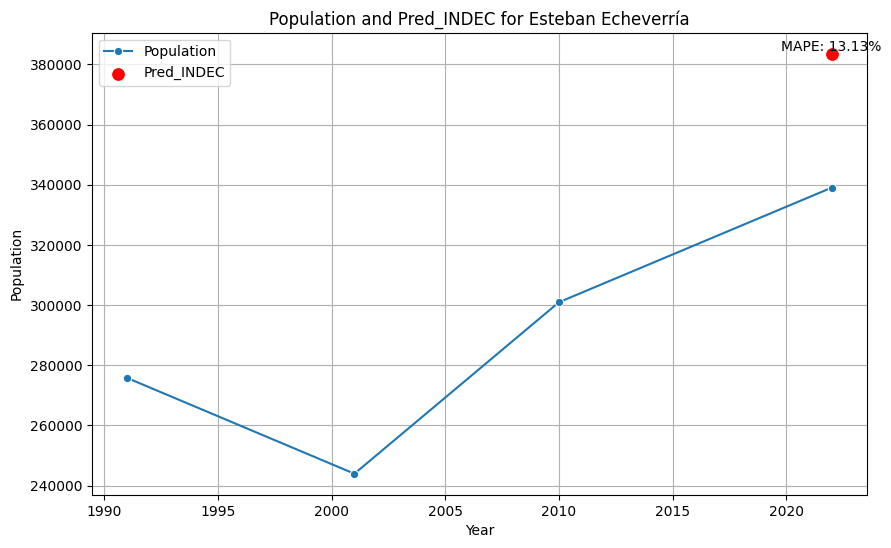

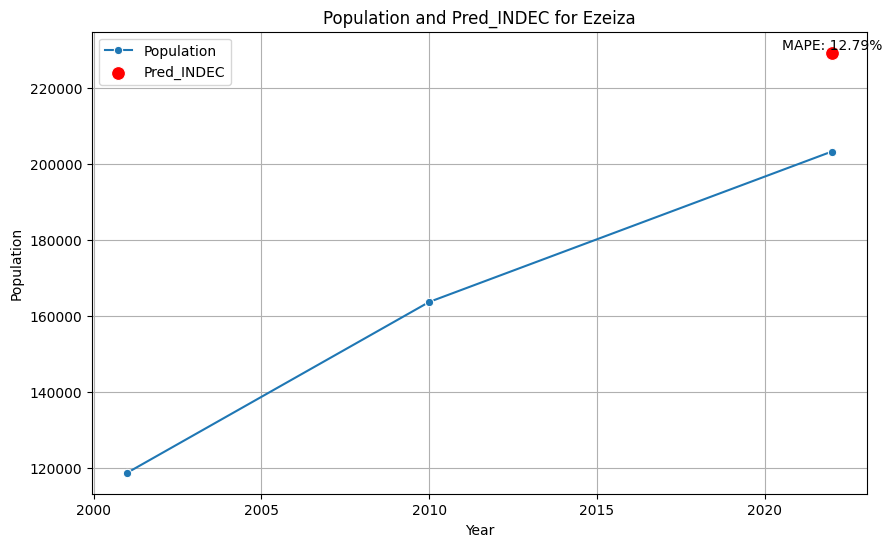

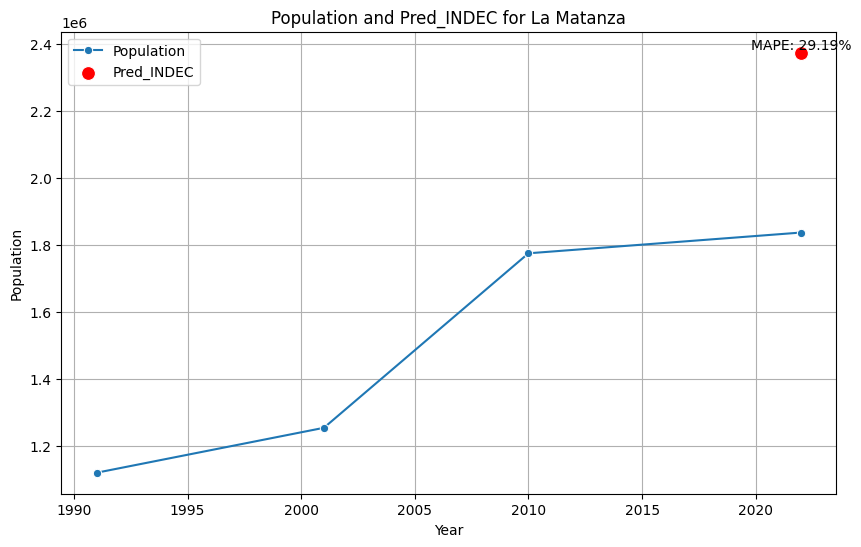

In [22]:
# Define the list of 'poor' departments
poor_depts = ['Esteban Echeverría', 'Ezeiza', 'La Matanza']

# Loop through the poor departments and create individual plots
for dept in poor_depts:
    # Filter the data for the specific department
    dept_data = merged_df[merged_df['Departamento'] == dept]

    # Create a line plot for population over the years
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dept_data, x='ano', y='pob', marker='o', linestyle='-', label='Population')
    
    # Scatter plot for 2022 with Pred_INDEC
    scatter_data = dept_data[dept_data['ano'] == 2022]
    sns.scatterplot(data=scatter_data, x='ano', y='Pred_INDEC', color='red', s=100, label='Pred_INDEC')
    
    # Add text with MAPE_Pred_INDEC as a label
    for index, row in scatter_data.iterrows():
        plt.text(row['ano'], row['Pred_INDEC'], f"MAPE: {row['MAPE_Pred_INDEC']:.2f}%", 
                 color='black', fontsize=10, ha='center', va='bottom')
    
    # Customize the plot
    plt.title(f"Population and Pred_INDEC for {dept}")
    plt.xlabel("Year")
    plt.ylabel("Population")
    plt.legend()
    plt.grid(True)
    plt.show()


indec falla donde el GR 2010/2000 es alto( mayor al promedio) y después baja........ especialmente en elcaso de la matanza..



### COmparativa de Modelos over all depts

In [27]:

#data_2022=data_2022.drop(columns=['Population_Category'	,'Population_Category_y'])

print(data_2022.columns)
data_2022

Index(['Departamento', 'cod_depto', 'ano', 'pob', 'var', 'muj', 'vivpart',
       'vivtotal', 'sup', 'ind_masc', 'dens_pob', 'TMI', 'TGF', 'TBN', 'TBM',
       'TCV', 'Mat1ria', 'Pred_LR', 'MAPE_LR', 'MSE_LR', 'RMSE_LR',
       'PredRegTree', 'MAPE_RT', 'MSE_RT', 'RMSE_RT', 'Pred_RF', 'MSE_RF',
       'RMSE_RF', 'MAPE_RF', 'Pred_LGB', 'MSE_LGB', 'RMSE_LGB', 'MAPE_LGB',
       'Pred_INDEC', 'MAPE_Pred_INDEC', 'MSE_INDEC', 'RMSE_INDEC',
       'Population_Category', 'Population_Category_y'],
      dtype='object')


,Departamento,cod_depto,ano,pob,var,muj,vivpart,vivtotal,sup,ind_masc,...,Pred_LGB,MSE_LGB,RMSE_LGB,MAPE_LGB,Pred_INDEC,MAPE_Pred_INDEC,MSE_INDEC,RMSE_INDEC,Population_Category,Population_Category_y
2,Almirante Brown,6028,2022,585852.0,281842.0,301779.0,184403.0,60.0,157.87,93.4,...,506385.0,6.314951e+09,79466.666667,13.564290,605271.0,3.31,6.527387e+09,80792.2,Medium,Medium
7,Avellaneda,6035,2022,370939.0,174572.0,194911.0,144988.0,64.0,68.54,89.6,...,338883.0,1.027609e+09,32056.333333,8.641942,358512.0,3.35,6.527387e+09,80792.2,Low,Low
9,Berazategui,6091,2022,360582.0,173892.0,186255.0,117699.0,37.0,268.91,93.4,...,285695.0,5.608013e+09,74886.666667,20.768276,372889.0,3.41,6.527387e+09,80792.2,Low,Low
12,Esteban Echeverría,6260,2022,339030.0,163974.0,174468.0,109969.0,40.0,148.12,94.0,...,273575.0,4.284313e+09,65454.666667,19.306453,383538.0,13.13,6.527387e+09,80792.2,Low,Low
19,Ezeiza,6270,2022,203283.0,97766.0,102703.0,65987.0,18.0,291.00,95.2,...,NaN,NaN,NaN,NaN,229276.0,12.79,6.527387e+09,80792.2,Low,Low
21,Florencio Varela,6274,2022,497818.0,239305.0,250192.0,145546.0,26.0,231.51,95.6,...,343324.0,2.386840e+10,154494.000000,31.034233,533446.0,7.16,6.527387e+09,80792.2,Low,Low
24,General San Martín,6371,2022,450335.0,213300.0,233690.0,175969.0,113.0,68.80,91.3,...,408037.0,1.789093e+09,42297.666667,9.392489,426556.0,5.28,6.527387e+09,80792.2,Medium,Medium
28,Hurlingham,6408,2022,187122.0,89551.0,97118.0,66033.0,19.0,43.57,92.2,...,NaN,NaN,NaN,NaN,195596.0,4.53,6.527387e+09,80792.2,Low,Low
32,Ituzaingó,6410,2022,179788.0,84855.0,92708.0,64175.0,37.0,46.38,91.5,...,NaN,NaN,NaN,NaN,182993.0,1.78,6.527387e+09,80792.2,Low,Low
36,José C. Paz,6412,2022,323918.0,157631.0,165831.0,97098.0,27.0,61.03,95.1,...,NaN,NaN,NaN,NaN,314878.0,2.79,6.527387e+09,80792.2,Low,Low


### CUADRO CON PREDiCIONES Y ERRORES PARA INCLUIR EN EL ANExo

In [28]:
df=data_2022
df=df.drop(columns=[ 'var', 'muj', 'vivpart','ano','cod_depto',
       'vivtotal', 'sup', 'ind_masc', 'dens_pob', 'TMI', 'TGF', 'TBN', 'TBM',
       'TCV', 'Mat1ria','Population_Category'	,'Population_Category_y'])

In [29]:
## RENAME COLUMNS  
df=df.rename(columns={'pob':'Censo 2022', 'MAPE_Pred_INDEC':'MAPE_INDEC','PredRegTree':'Pred_RT'})

In [30]:

# Format numbers with thousand separators
def format_number(x):
    if isinstance(x, (int, float)):
        if x >= 1e7:  # Numbers greater than or equal to 1e7
            return f"{x:.1e}"
        elif x >= 1e4:  # Numbers greater than or equal to 1e4
            return f"{x:,.0f}"
        else:  # Smaller numbers
            return f"{x:,.2f}"
    return x

# Apply formatting
df = df.applymap(format_number)

# Identify columns to reorder
pred_columns = [col for col in df.columns if 'Pred' in col]
mape_columns = [col for col in df.columns if 'MAPE' in col]
mse_columns = [col for col in df.columns if 'MSE' in col]

# Construct new column order
new_order = (
    [col for col in df.columns if col not in pred_columns + mape_columns  + mse_columns]+
    pred_columns + mape_columns  + mse_columns
)

# Reorder columns
df = df[new_order]

# Display the DataFrame
print(df)

           Departamento Censo 2022    Pred_LR    Pred_RT    Pred_RF  \
2       Almirante Brown    585,852    602,696    552,902    521,336   
7            Avellaneda    370,939    360,939    342,677    337,916   
9           Berazategui    360,582    372,685    287,913    295,665   
12   Esteban Echeverría    339,030    376,939    243,974    278,778   
19               Ezeiza    203,283    223,608    118,807        nan   
21     Florencio Varela    497,818    528,718    426,005    367,660   
24   General San Martín    450,335    428,981    403,107    409,244   
28           Hurlingham    187,122    193,235    181,241        nan   
32            Ituzaingó    179,788    180,761    167,824        nan   
36          José C. Paz    323,918    313,678    265,981        nan   
43           La Matanza  1,837,774  2,469,853  1,775,816  1,437,887   
44                Lanús    462,051    467,504    453,082    459,486   
48      Lomas de Zamora    694,330    649,524    591,345    599,412   
55  Ma

C:\Users\Fer\AppData\Local\Temp\ipykernel_19924\66400699.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(format_number)


In [31]:

# Method-specific column subsets
methods = ['LR', 'RT', 'RF', 'LGB','INDEC']
dataframes = {}

for method in methods:
    subset_columns = ['Departamento', 'Censo 2022'] + \
                     [f'Pred_{method}', f'MAPE_{method}', f'MSE_{method}', f'RMSE_{method}']
    # Create DataFrame for the current method
    df_method = df[subset_columns]
    dataframes[method] = df_method

# Access individual DataFrames
df_LR = dataframes['LR']
df_RT = dataframes['RT']
df_RF = dataframes['RF']
df_LGB = dataframes['LGB']
df_INDEC = dataframes['INDEC']


# Display the DataFrames
print("DataFrame for LR:")
print(df_LR)
print("\nDataFrame for RT:")
print(df_RT)
print("\nDataFrame for RF:")
print(df_RF)
print("\nDataFrame for LGB:")
print(df_LGB)
print("\nDataFrame for INDEC:")
print(df_INDEC)

DataFrame for LR:
           Departamento Censo 2022    Pred_LR MAPE_LR     MSE_LR   RMSE_LR
2       Almirante Brown    585,852    602,696    2.88    2.8e+08    16,845
7            Avellaneda    370,939    360,939    2.70    1.0e+08  9,999.30
9           Berazategui    360,582    372,685    3.36    1.5e+08    12,103
12   Esteban Echeverría    339,030    376,939   11.18    1.4e+09    37,909
19               Ezeiza    203,283    223,608   10.00    4.1e+08    20,326
21     Florencio Varela    497,818    528,718    6.21    9.6e+08    30,900
24   General San Martín    450,335    428,981    4.74    4.6e+08    21,354
28           Hurlingham    187,122    193,235    3.27    3.7e+07  6,113.70
32            Ituzaingó    179,788    180,761    0.54    947,000    973.30
36          José C. Paz    323,918    313,678    3.16    1.0e+08    10,240
43           La Matanza  1,837,774  2,469,853   34.39    4.0e+11   632,079
44                Lanús    462,051    467,504    1.18    3.0e+07  5,453.30
48     

In [32]:
dataframe_to_latex(df_LR,'LRResult.tex')
dataframe_to_latex(df_RT,'RTResult.tex')
dataframe_to_latex(df_RF,'RFResult.tex')
dataframe_to_latex(df_LGB,'LGBResult.tex')
dataframe_to_latex(df_INDEC,'INDECResult.tex')


### PRED AND MAPE

In [ ]:

# Initialize a list to hold the result DataFrames
result_dfs = []

# Methods to process
methods = ['LR', 'RT', 'RF', 'LGB', 'INDEC']

for method in methods:
    # Define relevant columns
    pred_col = f'Pred_{method}'
    mape_col = f'MAPE_{method}'
    
    # Ensure MAPE column is numeric
    df[mape_col] = pd.to_numeric(df[mape_col], errors='coerce')
    
    # Create a subset DataFrame
    subset_df = df[['Departamento', 'Censo 2022', pred_col, mape_col]].copy()
    
    # Format the MAPE column as percentage and combine with Pred column
    subset_df[pred_col] = subset_df.apply(
        lambda row: f"{row[pred_col]} ({row[mape_col]:.1f}%)" if pd.notna(row[mape_col]) else row[pred_col],
        axis=1
    )
    
    # Drop the MAPE column as it's now included in the Pred column
    subset_df.drop(columns=[mape_col], inplace=True)
    
    # Append the DataFrame to the result list
    result_dfs.append(subset_df)

# Display DataFrames for each method
for method, result_df in zip(methods, result_dfs):
    print(f"\nDataFrame for {method}:")
    print(result_df)

In [ ]:
# Methods to process, including INDEC
methods = ['LR', 'RT', 'RF', 'LGB', 'INDEC']

# DataFrame to hold all predictions with formatted MAPE
all_predictions_df = pd.DataFrame()
# DataFrame to hold combined predictions
combined_predictions_df = pd.DataFrame()

for method in methods:
    # Define relevant columns
    pred_col = f'Pred_{method}' if method != 'INDEC' else 'Pred_INDEC'
    mape_col = f'MAPE_{method}' if method != 'INDEC' else 'MAPE_INDEC'
    
    # Ensure MAPE column is numeric
    df[mape_col] = pd.to_numeric(df[mape_col], errors='coerce')
    
    # Create a subset DataFrame with formatted predictions
    subset_df = df[['Departamento', 'Censo 2022', pred_col, mape_col]].copy()
    
    # Format the MAPE column as percentage and combine with Pred column
    subset_df[pred_col] = subset_df.apply(
        lambda row: f"{row[pred_col]} ({row[mape_col]:.1f}%)" if pd.notna(row[mape_col]) else row[pred_col],
        axis=1
    )
    
    # Drop the MAPE column as it's now included in the Pred column
    subset_df.drop(columns=[mape_col], inplace=True)
    
    # Avoid repeating Departamento and Censo 2022 columns
    if all_predictions_df.empty:
        all_predictions_df = subset_df
    else:
        # Merge to avoid repeating Departamento and Censo 2022 columns
        all_predictions_df = pd.merge(all_predictions_df, subset_df, on=['Departamento', 'Censo 2022'])
    
    # Create a DataFrame for the combined predictions
    combined_predictions_df = pd.concat([
        combined_predictions_df,
        df[['Departamento', 'Censo 2022', pred_col]].rename(columns={pred_col: f'{method}_Prediction'})
    ], axis=1)

# Drop duplicated columns in combined_predictions_df
combined_predictions_df = combined_predictions_df.loc[:,~combined_predictions_df.columns.duplicated()]

# Display the DataFrames
print("\nAll Predictions DataFrame:")
print(all_predictions_df)

print("\nCombined Predictions DataFrame:")
print(combined_predictions_df)


In [ ]:
dataframe_to_latex(combined_predictions_df,'combined_predictions_df.tex')
dataframe_to_latex(all_predictions_df,'all_predictions_df.tex')

###  Typical ERRORS for EVERY MEthod

In [ ]:
df=data_2022
# Calculate the average MSE for each prediction method
mse_cols = df.filter(regex='^MSE_').mean()
print("Average MSE for each method:")
print(mse_cols)

# Calculate the average RMSE for each prediction method
rmse_cols = df.filter(regex='^RMSE_').mean()
print("\nAverage RMSE for each method:")
print(rmse_cols)

# Calculate the average MAPE for each prediction method
mape_cols = df.filter(regex='^MAPE_').mean()
print("\nAverage MAPE for each method:")
print(mape_cols)


In [ ]:
# Calculate the average values for each error metric and each method
mse_cols = df.filter(regex='^MSE_').mean()
rmse_cols = df.filter(regex='^RMSE_').mean()
mape_cols = df.filter(regex='^MAPE_').mean()

# Create a DataFrame with the method as the index and error metrics as columns
average_errors = pd.DataFrame({
    'Method': ['Linear Regression', 'Regression Trees', 'Random Forest', 'LightGBM', 'INDEC'],
    'MSE': mse_cols.values.round(0),
    'RMSE': rmse_cols.values.round(0),
    'MAPE': mape_cols.values.round(1)
})
average_errors[['MSE']] = average_errors[['MSE']].applymap(lambda x: f'{x:.1e}')
# Set 'Method' as the index to align with your requirement (optional)
average_errors.set_index('Method', inplace=False)

# Display the table
print(average_errors)


In [ ]:
dataframe_to_latex(average_errors,'CuadroAvgErrors.tex')

### EVERY BOX PLOT

In [ ]:
df=df.rename(columns={'MAPE_Pred_INDEC':'MAPE_INDEC'})
# Melt the DataFrame to a long format for easier plotting
errors_df = df.melt(id_vars=['Departamento'], 
                    value_vars=['MSE_LR', 'RMSE_LR', 'MAPE_LR', 'MSE_RT', 'RMSE_RT', 'MAPE_RT',
                                'MSE_RF', 'RMSE_RF', 'MAPE_RF', 'MSE_LGB', 'RMSE_LGB', 'MAPE_LGB',
                                'MSE_INDEC', 'RMSE_INDEC', 'MAPE_INDEC'],
                    var_name='Error_Method', 
                    value_name='Error_Value')

# Split 'Error_Method' into separate columns for Error Type and Method
errors_df[['Error_Type', 'Method']] = errors_df['Error_Method'].str.split('_', expand=True)

# Display the reshaped DataFrame
print(errors_df.head())


In [ ]:

# Melt the DataFrame to a long format for easier plotting
errors_df = df.melt(id_vars=['Departamento'], 
                    value_vars=['MSE_LR', 'RMSE_LR', 'MAPE_LR', 'MSE_RT', 'RMSE_RT', 'MAPE_RT',
                                'MSE_RF', 'RMSE_RF', 'MAPE_RF', 'MSE_LGB', 'RMSE_LGB', 'MAPE_LGB',
                                'MSE_INDEC', 'RMSE_INDEC', 'MAPE_INDEC'],
                    var_name='Error_Method', 
                    value_name='Error_Value')

# Split 'Error_Method' into separate columns for Error Type and Method
errors_df[['Error_Type', 'Method']] = errors_df['Error_Method'].str.split('_', expand=True)
# Assuming your data is already reshaped into errors_df
# Here's a quick reminder of how your errors_df should look:
# errors_df has columns: ['Departamento', 'Error_Method', 'Error_Value', 'Error_Type', 'Method']

# Loop over each error type and plot the boxplot
for error_type in ['MSE', 'RMSE', 'MAPE']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=errors_df[errors_df['Error_Type'] == error_type], x='Method', y='Error_Value')
    plt.title(f'Boxplot of {error_type} by Method')
    plt.xlabel('Method')
    plt.ylabel(f'{error_type} Value')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


### MAPE BOX PLOT

In [ ]:

# Filter columns that start with 'MAPE'
mape_columns = [col for col in df.columns if col.startswith('MAPE')]

# Create a box plot
df[mape_columns].boxplot(figsize=(10, 6))
plt.title('Box Plot of MAPE Columns')
plt.ylabel('MAPE Values')
plt.xlabel('MAPE Methods')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Mapping of column prefixes to prediction methods
method_mapping = {
    'MAPE_LR': 'Linear Regression',
    'MAPE_RT': 'Regression Tree',
    'MAPE_RF': 'Random Forest',
    'MAPE_LGB': 'LightGBM',
    'MAPE_Pred_INDEC': 'INDEC'
}

# Filter columns that start with 'MAPE'
mape_columns = [col for col in df.columns if col.startswith('MAPE')]

# Create a box plot
boxplot = df[mape_columns].boxplot(figsize=(12, 8))

# Set x-axis labels using the mapping
method_labels = [method_mapping[col] for col in mape_columns]
boxplot.set_xticklabels(method_labels, rotation=45)

# Set plot title and labels
plt.title('Box Plot MAPE por modelo')
plt.ylabel('MAPE ')
plt.xlabel('Modelo')
plt.grid(True)

# Show plot
plt.show()


##### Cuadro Estadístico comparativo

In [ ]:
import pandas as pd

# Mapping of column prefixes to prediction methods
method_mapping = {
    'MAPE_LR': 'Linear Regression',
    'MAPE_RT': 'Regression Tree',
    'MAPE_RF': 'Random Forest',
    'MAPE_LGB': 'LightGBM',
    'MAPE_Pred_INDEC': 'INDEC'
}

# Initialize lists to store statistics and outliers
stats_data = []
outliers_data = []

# Filter columns that start with 'MAPE'
mape_columns = [col for col in df.columns if col.startswith('MAPE')]

# Calculate statistics and collect outliers
for col in mape_columns:
    method = method_mapping[col]
    q1 = df[col].quantile(0.25)
    median = df[col].median()
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][['Departamento', col]]
    outliers_data.append(outliers)
    stats_data.append({'Method': method, 'Q1': round(q1, 1), 'Median': round(median, 1), 'Q3': round(q3, 1), 'IQR': round(iqr, 1), 'Lower Bound': round(lower_bound, 1), 'Upper Bound': round(upper_bound, 1)})

# Create DataFrame for statistics
stats_df = pd.DataFrame(stats_data)

# Create DataFrame for outliers
outliers_df = pd.concat(outliers_data, ignore_index=True)

# Display statistics DataFrame
print("Statistics for each box plot:")
print(stats_df)

# Display outliers DataFrame
print("\nOutliers for each method:")
print(outliers_df)


In [ ]:
grouped_outliers = outliers_df.groupby('Departamento').first().reset_index()

# Display the grouped outliers
print("Outliers grouped by 'Departamento':")
print(grouped_outliers)


In [ ]:
# Specify the columns and 'Departamento' values
selected_columns = ['MAPE_LR', 'MAPE_RT', 'MAPE_RF', 'MAPE_LGB', 'MAPE_Pred_INDEC']
selected_departamentos = ['Esteban Echeverría', 'Ezeiza', 'La Matanza', 'Moreno']

# Create the subdataset
df_outliers = df.loc[df['Departamento'].isin(selected_departamentos), ['Departamento'] + selected_columns]

# Display the subdataset
print("Subdataset:")
print(df_outliers)


In [ ]:
## To LATEX... 
dataframe_to_latex(stats_df.head(12),'StatsModelos.tex')
dataframe_to_latex(df_outliers,'OutliersModelos.tex')

#### PARA LOS 2 modelos más precisos La Matanza Represnta un Outlier

## ANALISIS SINGULAR LA MATANZA

In [ ]:
Mega_df.head()

In [ ]:
full_df.head()

In [ ]:
# Select the specified columns from full_df and exclude rows where ano == 2022
columns_to_append = ["Departamento", "pob", "ano"]
subset_full_df = full_df[(full_df["ano"] != 2022)][columns_to_append]

# Append the selected rows to MEga
Mega_df = pd.concat([Mega_df, subset_full_df], ignore_index=True)

# Display the updated MEga
print("Updated MEga:")
print(Mega_df)


In [ ]:
# Ensure MEga DataFrame is sorted by 'Departamento' and 'ano'
Mega_df = Mega_df.sort_values(by=['Departamento', 'ano']).reset_index(drop=True)

# Calculate the growth ratio
growth_ratios = Mega_df.groupby('Departamento')['pob'].apply(lambda x: (x - x.shift(1)) / x.shift(1) * 100)

# Assign the growth ratios back to the DataFrame
Mega_df['Growth_Ratio'] = growth_ratios.values

# Display the updated MEga DataFrame
print("Updated MEga with Growth Ratio:")
print(Mega_df)


In [ ]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for "La Matanza"
la_matanza_df = Mega_df[Mega_df['Departamento'] == 'La Matanza']

# Step 2: Create a line plot for 'ano' vs 'pob'
plt.figure(figsize=(12, 8))
plt.plot(la_matanza_df['ano'], la_matanza_df['pob'], marker='o', label='Population')

# Step 3: Add scatter plots for 'Growth_Ratio' with labels (excluding 1991 due to NaN)
for index, row in la_matanza_df.iterrows():
    if not pd.isna(row['Growth_Ratio']):
        plt.scatter(row['ano'], row['pob'], color='red')
        plt.text(row['ano'], row['pob'], f"GR: {row['Growth_Ratio']:.1f}%", fontsize=9, ha='left', color='black')

# Step 4: Overlay 'Pred_INDEC', 'Pred_LR' values and their corresponding 'MAPE_Pred_INDEC' and 'MAPE_LR' labels
for index, row in la_matanza_df.iterrows():
    plt.scatter(row['ano'], row['Pred_INDEC'], color='blue')
    plt.text(row['ano'], row['Pred_INDEC'], f" MAPE_INDEC: {row['MAPE_Pred_INDEC']:.1f}%", fontsize=9, ha='right', color='blue')
    
    plt.scatter(row['ano'], row['Pred_LR'], color='green')
    plt.text(row['ano'], row['Pred_LR'], f"MAPE_LR: {row['MAPE_LR']:.1f}%", fontsize=9, ha='right', color='green')

# Adding labels and legend
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('La Matanza')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [ ]:
# Grouping by 'ano' and calculating the average growth ratio
average_growth_ratio = Mega_df.groupby('ano')['Growth_Ratio'].mean()
max_growth_ratio = Mega_df.groupby('ano')['Growth_Ratio'].max()
min_growth_ratio = Mega_df.groupby('ano')['Growth_Ratio'].min()
# Displaying the result
print("Average Growth Ratio for Each Year:")
print(average_growth_ratio)
print(max_growth_ratio)
print(min_growth_ratio)

In [ ]:
# List of Departamento values to exclude for the year 2001
exclude_departamentos_2001 = ['Esteban Echeverría', 'Ezeiza', 'Florencio Varela', 'Hurlingham', 'Ituzaingó', 'José C. Paz', 'Malvinas Argentinas', 'Morón', 'San Miguel', 'General Sarmiento']

# Filter the DataFrame to exclude specified Departamentos for the year 2001
filtered_MEga_2001 = Mega_df[~((Mega_df['ano'] == 2001) & (Mega_df['Departamento'].isin(exclude_departamentos_2001)))]

# Grouping by 'ano' and calculating the average growth ratio
average_growth_ratio_2001 = filtered_MEga_2001.groupby('ano')['Growth_Ratio'].mean()

max_growth_ratio = filtered_MEga_2001.groupby('ano')['Growth_Ratio'].max()
min_growth_ratio = filtered_MEga_2001.groupby('ano')['Growth_Ratio'].min()
# Displaying the result
print("Average Growth Ratio for Each Year:")
print(average_growth_ratio_2001)
print(max_growth_ratio)
print(min_growth_ratio)

In [ ]:
# Calculate the average of the 'mean' column
mean_column_average = Mega_df['Mean'].mean()
mean_LM=Mega_df['Mean'].mean()
# Display the result
print("Average of the 'mean' column:", mean_column_average)


In [ ]:
# Filter the MEga DataFrame for 'La Matanza'
la_matanza_data = Mega_df[Mega_df['Departamento'] == 'La Matanza']

# Calculate the mean value for La Matanza
mean_value_la_matanza = la_matanza_data['Mean'].mean()

# Display the result
print("Mean value for 'La Matanza':", mean_value_la_matanza)


In [ ]:
# Filter the MEga DataFrame for specific years [1991, 2001, 2010]
MEga_specific_years = filtered_MEga_2001[filtered_MEga_2001['ano'].isin([1991, 2001, 2010])]

# Calculate the mean value for the 'mean' column for specific years
mean_column_average_specific_years = MEga_specific_years['Growth_Ratio'].mean()

# Display the result
print("Mean value for 'GR' column for years 1991, 2001, and 2010:", mean_column_average_specific_years)
min = MEga_specific_years['Growth_Ratio'].min()

# Display the result
print("Mean value for 'GR' column for years 1991, 2001, and 2010:", min)

max = MEga_specific_years['Growth_Ratio'].max()

# Display the result
print("Mean value for 'GR' column for years 1991, 2001, and 2010:", max)



In [ ]:
# Filter the MEga DataFrame for 'La Matanza' and specific years [1991, 2001, 2010]
la_matanza_data_specific_years = Mega_df[(Mega_df['Departamento'] == 'La Matanza') & (Mega_df['ano'].isin([1991, 2001, 2010]))]

# Calculate the mean value for La Matanza for specific years
mean_value_la_matanza_specific_years = la_matanza_data_specific_years['Growth_Ratio'].mean()

# Display the result
print("Mean value for 'La Matanza' for years 1991, 2001, and 2010:", mean_value_la_matanza_specific_years)


In [ ]:
print(3.5/10.566975)

EZEizA

In [ ]:
# Filter the MEga DataFrame for 'La Matanza' and specific years [1991, 2001, 2010]
ezeiza_df = Mega_df[(Mega_df['Departamento'] == 'Ezeiza')]

print(ezeiza_df)
